# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 1:

>- Juan Pablo Baudoin
>- Fran Cassinese
>- Martin Gruber
>- Mariana Abayay


# Análisis exploratorio

In [6]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
from pycountry import languages
from langid.langid import LanguageIdentifier, model

from lib.utils import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
# Estos paquetes son necesarios para el código (y no vienen instalados por defecto en Anaconda),
# descomentar los módulos que falten para instalarlos:

# !pip install emoji --upgrade --quiet
# !pip install pycountry --upgrade --quiet
# !pip install langdetect --upgrade --quiet
# !pip install pandarallel --upgrade --quiet
# !pip install langid --upgrade --quiet


## 1. Lectura de datos

In [8]:
base_name = "signals_langs"
src_ds = f"data/{base_name}.csv"
df_ori = pd.read_csv(src_ds)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936272 entries, 0 to 936271
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       936272 non-null  int64  
 1   commodity                751982 non-null  object 
 2   source_posted_at         936272 non-null  object 
 3   trade_type               935079 non-null  object 
 4   chat_id                  934972 non-null  float64
 5   telegram_user_id         936272 non-null  int64  
 6   message_text             936233 non-null  object 
 7   message_text_translated  451354 non-null  object 
 8   language                 896118 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 64.3+ MB


In [9]:
# check if a file exists
import os
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df_ori.to_csv(work_file, index=False)
    df = df_ori.copy()
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)
    df['date_source_posted_at'] = pd.to_datetime(df['date_source_posted_at'])

df.info()


File data/signals_langs_enhanced.csv already exists. Loading it.


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_11177/2396233977.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work_file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445265 entries, 0 to 445264
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       445265 non-null  int64              
 1   commodity                356095 non-null  object             
 2   source_posted_at         445265 non-null  object             
 3   trade_type               444798 non-null  object             
 4   chat_id                  445265 non-null  float64            
 5   telegram_user_id         445265 non-null  int64              
 6   message_text             445265 non-null  object             
 7   message_text_translated  1170 non-null    object             
 8   language                 445265 non-null  object             
 9   date_source_posted_at    445265 non-null  datetime64[ns, UTC]
 10  message_text_clean       445265 non-null  object             
 11  message_encod

## 2. Análisis de datos categóricos y texto
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categóricas: commodity, trade_type, chat_id, telegram_user_id
- Análisis del campo message_text: mediante una inspección de datos muestral se ve que existen varios idiomas, que se tienen múltiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el análisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



In [10]:
# group df by id and count the number of rows
df_grouped_id = df.groupby('id').size().reset_index(name='counts')
# sort the values by counts
df_grouped_id = df_grouped_id.sort_values(by='counts', ascending=False)
df_grouped_id

,id,counts
69928,170445,355
69927,170444,343
69666,170174,342
70030,170552,334
69873,170387,326
...,...,...
42608,49842,1
93781,198137,1
93780,198136,1
93779,198135,1


In [11]:
# Creamos una columna id con el índice de la tabla
df['id_msg'] = df.index


### 2.1 Nulos

In [12]:
# get the percentage of missing values in the dataset
missing_values = df_ori.isnull().mean() * 100
# sort the columns by the percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columns with missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columns with no missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")

############
Columns with missing values
    message_text_translated: 51.79%
    commodity: 19.68%
    language: 4.29%
    chat_id: 0.14%
    trade_type: 0.13%
    message_text: 0.00%
############
Columns with no missing values
    id
    source_posted_at
    telegram_user_id


In [13]:
# Excluir los registros sin chat_id
df = df.dropna(subset=['chat_id'])
df = df.dropna(subset=['message_text'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445265 entries, 0 to 445264
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       445265 non-null  int64              
 1   commodity                356095 non-null  object             
 2   source_posted_at         445265 non-null  object             
 3   trade_type               444798 non-null  object             
 4   chat_id                  445265 non-null  float64            
 5   telegram_user_id         445265 non-null  int64              
 6   message_text             445265 non-null  object             
 7   message_text_translated  1170 non-null    object             
 8   language                 445265 non-null  object             
 9   date_source_posted_at    445265 non-null  datetime64[ns, UTC]
 10  message_text_clean       445265 non-null  object             
 11  message_encod

## Filtado de mensajes en ingles

In [14]:
# filter the messages with language 'en'
flt_en = df['language'] == 'en'
df = df[flt_en]

print(f"Numero de mensajes en ingles: {df.shape[0]}")

Numero de mensajes en ingles: 445265


### 2.2. Frecuencias simples

#### 2.2.1. Top 10 de conteos

In [15]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - N/A: 89170 	 (20.03%  - 20.03%) 	 (NaN)
02 - BTC: 18192 	 (4.09%  - 24.12%) 	 (W/NaN 5.11% - 5.11%)
03 - ETH: 11180 	 (2.51%  - 26.63%) 	 (W/NaN 3.14% - 8.25%)
04 - LTC: 7017 	 (1.58%  - 28.21%) 	 (W/NaN 1.97% - 10.22%)
05 - DYDX: 4655 	 (1.05%  - 29.26%) 	 (W/NaN 1.31% - 11.53%)
06 - BNB: 4234 	 (0.95%  - 30.21%) 	 (W/NaN 1.19% - 12.72%)
07 - ATOM: 3606 	 (0.81%  - 31.02%) 	 (W/NaN 1.01% - 13.73%)
08 - MATIC: 3582 	 (0.8%  - 31.82%) 	 (W/NaN 1.01% - 14.74%)
09 - DOGE: 3498 	 (0.79%  - 32.61%) 	 (W/NaN 0.98% - 15.72%)
10 - AXS: 3453 	 (0.78%  - 33.39%) 	 (W/NaN 0.97% - 16.69%)
11 - GALA: 3382 	 (0.76%  - 34.15%) 	 (W/NaN 0.95% - 17.64%)
--------
Top 11 Canal (chat_id):
01 - 765.0: 43835 	 (9.84% - 9.84%)
02 - 277.0: 42925 	 (9.64% - 19.48%)
03 - 3739.0: 34819 	 (7.82% - 27.30%)
04 - 313.0: 32040 	 (7.2% - 34.50%)
05 - 3720.0: 27353 	 (6.14% - 40.64%)
06 - 3243.0: 14258 	 (3.2% - 43.84%)
07 - 3396.0: 13501 	 (3.03% - 46.87%)
08 - 2985.0: 11787 	 (2.65% 

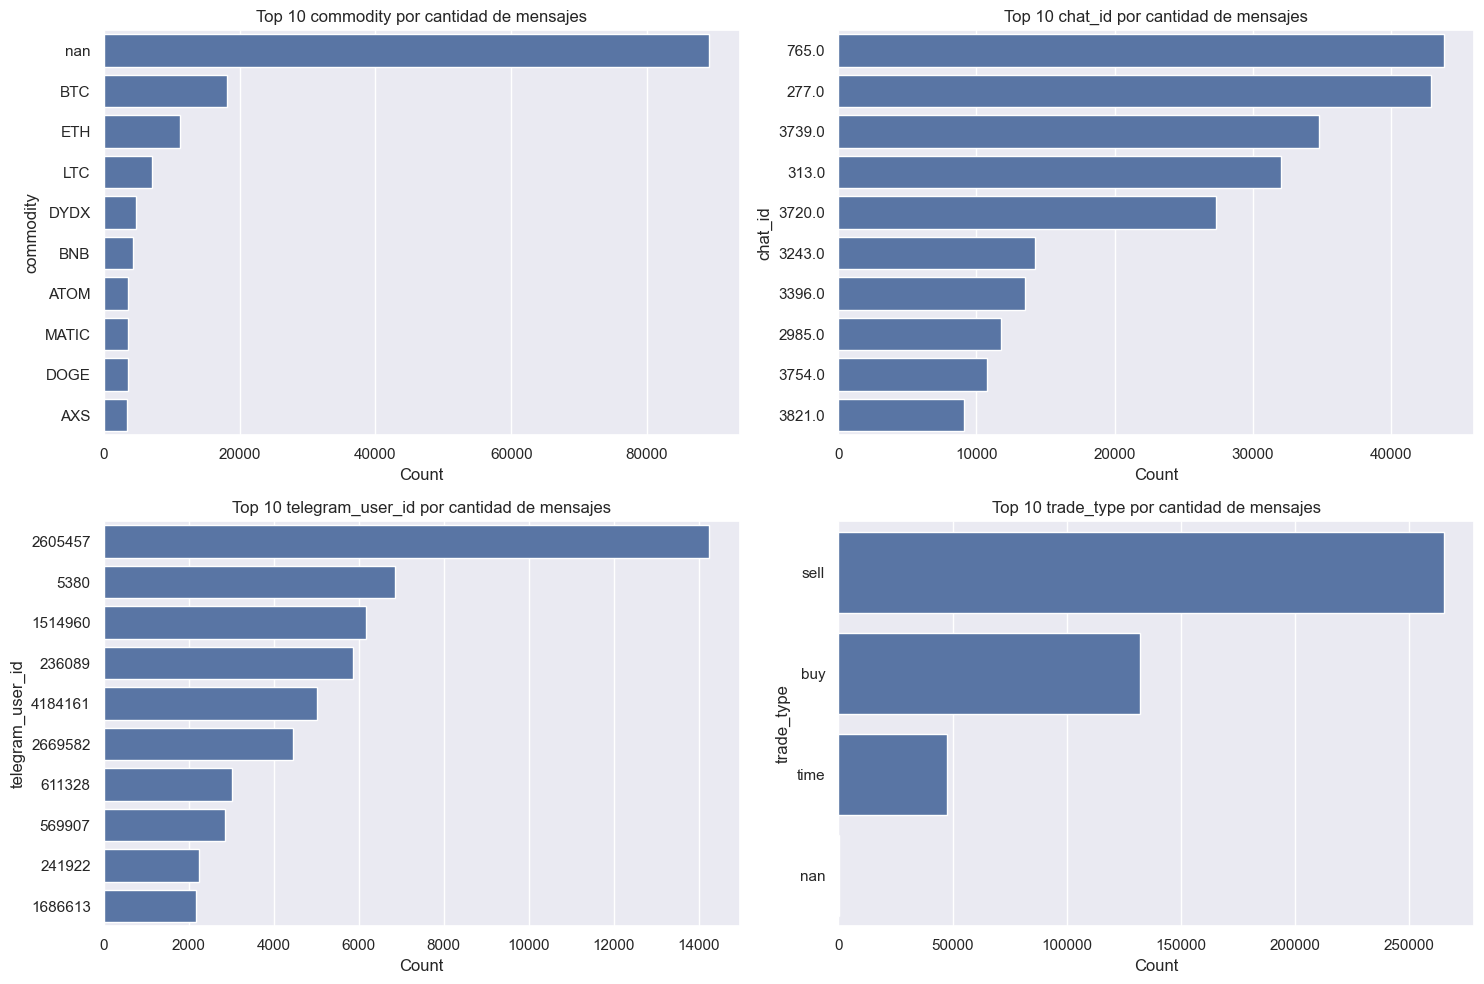

In [16]:
columns_to_plot = ['commodity', 'chat_id', 'telegram_user_id', 'trade_type']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    value_counts = df[column].astype(str).value_counts(dropna=False).head(10)
    
    # Convert value_counts to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    # Create the barplot
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 {column} por cantidad de mensajes')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2.2.2. Cruce de variables `telegram_user_id` y `chat_id`

In [17]:
# count the number of chat_ids
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

# count the number of users
users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")



Number of chat_ids: 1622
Number of users: 66217


In [18]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()} ({single_user_chats.count()/chat_ids:.2%})")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()} ({single_chat_users.count()/users:.2%})")


# Distribucion de numero de mensajes por canal


Number of chats with a single user: 1220 (75.22%)
Number of users with a single chat: 63898 (96.50%)


In [19]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 402
Number of chats with more than one user: 24.78%
chat_id
3739.0    10402
277.0      8128
3720.0     7366
3396.0     6200
3821.0     2308
          ...  
423.0         2
422.0         2
426.0         2
296.0         2
931.0         2
Name: telegram_user_id, Length: 402, dtype: int64
--------
Number of users with more than one chat: 2319
Number of users with more than one chat: 3.50%
telegram_user_id
5380       58
241922     30
172966     15
2628616     8
2628777     7
           ..
573275      2
3835052     2
3639049     2
2848285     2
1303662     2
Name: chat_id, Length: 2319, dtype: int64


### 2.3. Análisis del campo message_text
#### 2.3.1. Limpieza de datos y enriquecimiento simple

Para continuar con el análisis exploratorio, como indicamos antes, necesitamos realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo
    - Clean emojis: Remover los emojis
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8


In [20]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break

    # df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply
    # (lambda x: '\n'.join(line.strip() for line in x.splitlines() if line.strip()))

    try:
        cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    except Exception as e:
        print(text, type(text))
        print(e)
        cleaned_text = text
        raise e
    return cleaned_text
    

In [21]:
force_process = False

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################

    # Eliminar emojis y añadir columna message_no_emoji
    print("Cleaning Emojis")
    df['message_text_clean'] = df['message_text'].parallel_apply(remove_emojis).str.strip().str.lower()

    # # Detect the encoding of messages in the field message_text_clean of type string\
    print("Detecting encoding")
    df['message_encoding'] = df['message_text_clean'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Limpieza sobre el encoding utf8 ###
    #######################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    print("Convert to utf-8")
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    # print("Detecting encoding on new utf-8 messages")
    # df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Trim and remove multiple line breaks
    print("Cleaning LBR")
    df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply(clean_lbr)

    # Añadir columna con la longitud del mensaje sin emojis
    print("Checking message length")
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    print("Checking message words")
    df['message_words'] = df['message_text_clean_utf8'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df['message_lbr'] = df['message_text_clean_utf8'].parallel_apply(count_line_breaks)

    print("Store the processed data")
    df.to_csv(work_file, index=False)


In [22]:
# find messages with a length of 0
zero_length = df['message_length'] == 0
print(f"Number of messages with a length of 0: {zero_length.sum()}")

# drop messages with a length of 0
df = df[~zero_length]
df.to_csv(work_file, index=False)


Number of messages with a length of 0: 0


#### 2.3.3. Mensajes duplicados

In [23]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 191703
Percentage of duplicated messages: 43.05%
--------


In [24]:
duplicated_messages

,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,message_text_translated,language,date_source_posted_at,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words,message_lbr,id_msg
260309,169923,OCEAN,2022-08-29 12:57:58+00,sell,3368.0,2636993,!! USDT Available DIRECT !!\n\nLow price USTD ...,NaN,en,2022-08-29 12:57:58+00:00,!! usdt available direct !!\n\nlow price ustd ...,Windows-1254,!! usdt available direct !!\nlow price ustd av...,117,19,4,260309
260285,170114,NaN,2022-08-28 15:30:16+00,time,3368.0,2606657,!! USDT Available DIRECT !!\n\nLow price USTD ...,NaN,en,2022-08-28 15:30:16+00:00,!! usdt available direct !!\n\nlow price ustd ...,Windows-1254,!! usdt available direct !!\nlow price ustd av...,117,19,4,260285
249050,169128,NaN,2022-03-21 17:42:15+00,sell,3254.0,2606657,!! USDT Available DIRECT !!\n\nLow price USTD ...,NaN,en,2022-03-21 17:42:15+00:00,!! usdt available direct !!\n\nlow price ustd ...,Windows-1254,!! usdt available direct !!\nlow price ustd av...,117,19,4,249050
361717,10132,NaN,2022-10-21 13:40:18+00,buy,3739.0,2177437,!cache,NaN,en,2022-10-21 13:40:18+00:00,!cache,ascii,!cache,6,1,0,361717
384387,209587,NaN,2022-12-10 15:44:24+00,time,3739.0,2202445,!cache,NaN,en,2022-12-10 15:44:24+00:00,!cache,ascii,!cache,6,1,0,384387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234555,1073598,NaN,2022-10-09 18:26:26+00,NaN,3205.0,3076288,💗 龙腾集团🔠🔠🔠🔠🅰️🔠 老牌支付♥️\n\n💗 专注泰国、印度、巴西、越南、菲律宾一类...,NaN,en,2022-10-09 18:26:26+00:00,龙腾集团 老牌支付\n\n 专注泰国、印度、巴西、越南、菲律宾一类支付\n\n 印度代收代...,utf-8,龙腾集团 老牌支付\n专注泰国、印度、巴西、越南、菲律宾一类支付\n印度代收代付、印度原生...,459,68,13,234555
234512,1073181,NaN,2022-09-13 18:27:04+00,buy,3205.0,3076289,💗 龙腾集团🔠🔠🔠🔠🅰️🔠 老牌支付♥️\n\n💗 专注泰国、印度、巴西、越南、菲律宾一类...,NaN,en,2022-09-13 18:27:04+00:00,龙腾集团 老牌支付\n\n 专注泰国、印度、巴西、越南、菲律宾一类支付\n\n 印度代收代...,utf-8,龙腾集团 老牌支付\n专注泰国、印度、巴西、越南、菲律宾一类支付\n印度代收代付、印度原生...,459,68,13,234512
234492,1072701,NaN,2022-08-30 05:29:55+00,buy,3205.0,3076288,💗 龙腾集团🔠🔠🔠🔠🅰️🔠 老牌支付♥️\n\n💗 专注泰国、印度、巴西、越南、菲律宾一类...,NaN,en,2022-08-30 05:29:55+00:00,龙腾集团 老牌支付\n\n 专注泰国、印度、巴西、越南、菲律宾一类支付\n\n 印度代收代...,utf-8,龙腾集团 老牌支付\n专注泰国、印度、巴西、越南、菲律宾一类支付\n印度代收代付、印度原生...,459,68,13,234492
301057,161260,NaN,2022-05-15 12:00:29+00,time,3682.0,2972245,한국 시장은 P2E에 소극적인 편인데 이것에 대해 어떤 대응을 하고 계신가요?\n\...,NaN,en,2022-05-15 12:00:29+00:00,한국 시장은 p2e에 소극적인 편인데 이것에 대해 어떤 대응을 하고 계신가요?\n\...,utf-8,한국 시장은 p2e에 소극적인 편인데 이것에 대해 어떤 대응을 하고 계신가요?\nt...,115,24,1,301057


#### 2.3.4. Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

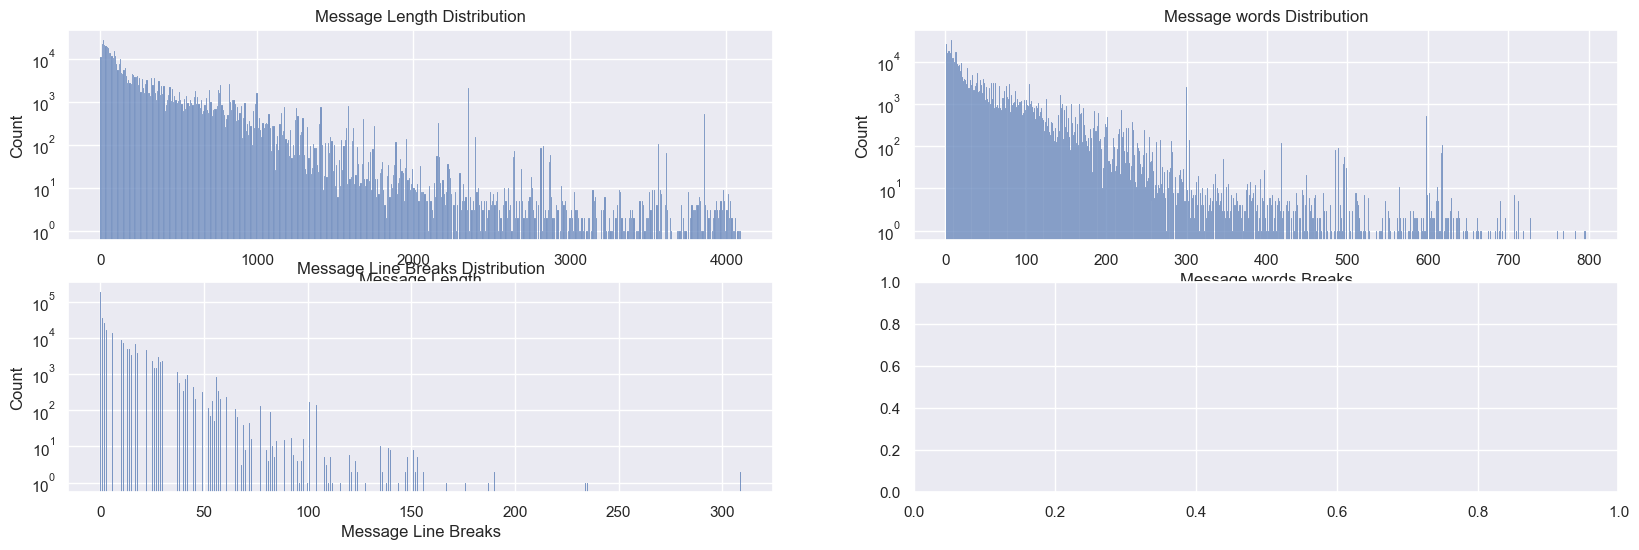

In [25]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado. Vemos que existen outliers en todas las distribuciones, los cuales podríamos analizar en más detalle.

In [26]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,445265.000000,445265.000000,445265.000000
mean,273.009545,41.582579,7.525606
std,406.528509,60.601867,13.720809
min,1.000000,1.000000,0.000000
25%,43.000000,7.000000,0.000000
50%,109.000000,17.000000,2.000000
75%,338.000000,52.000000,10.000000
max,4093.000000,797.000000,309.000000


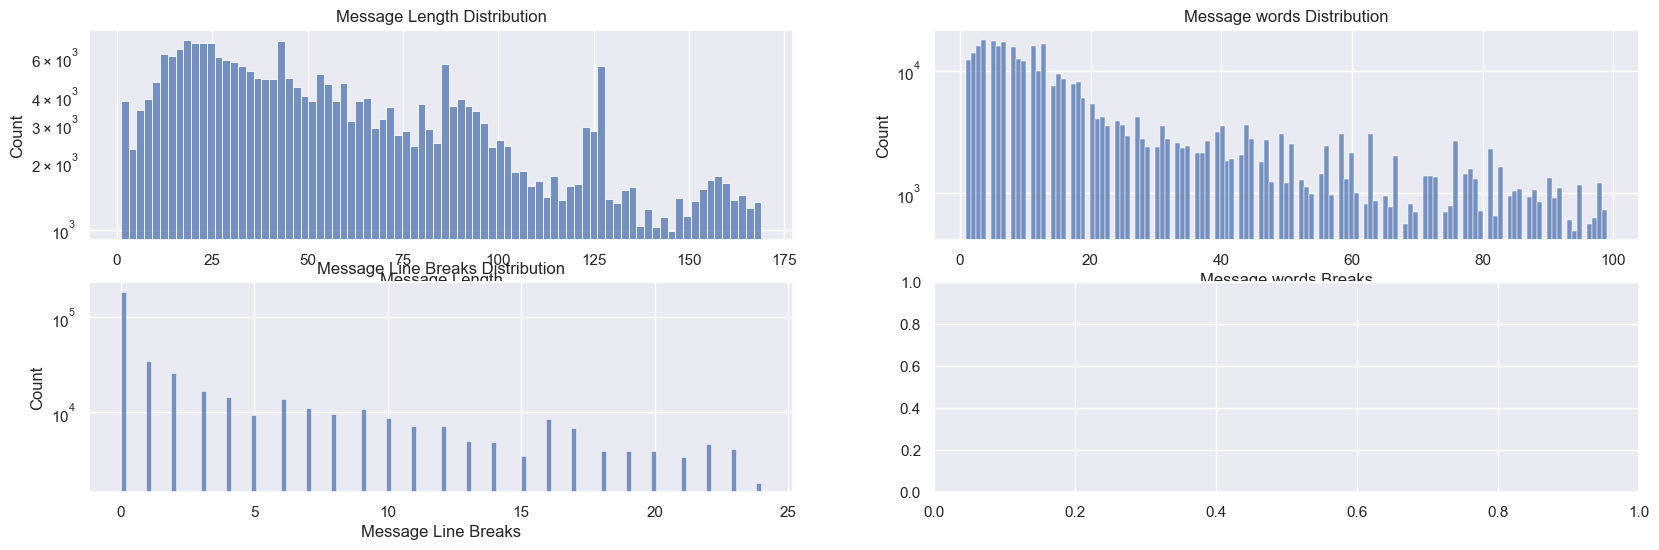

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

flt_mbr = (df['message_lbr'] < 25) & (df['message_lbr'] >= 0) 
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

In [28]:
print_top(df, 'message_lbr', "LBR", top=21)

Top 21 LBR (message_lbr):
01 - 0: 186286 	 (41.84% - 41.84%)
02 - 1: 34423 	 (7.73% - 49.57%)
03 - 2: 25967 	 (5.83% - 55.40%)
04 - 3: 16732 	 (3.76% - 59.16%)
05 - 4: 14521 	 (3.26% - 62.42%)
06 - 6: 13869 	 (3.11% - 65.53%)
07 - 7: 11212 	 (2.52% - 68.05%)
08 - 9: 10912 	 (2.45% - 70.50%)
09 - 8: 9484 	 (2.13% - 72.63%)
10 - 5: 9310 	 (2.09% - 74.72%)
11 - 10: 8648 	 (1.94% - 76.66%)
12 - 16: 8417 	 (1.89% - 78.55%)
13 - 11: 7173 	 (1.61% - 80.16%)
14 - 12: 7159 	 (1.61% - 81.77%)
15 - 17: 6796 	 (1.53% - 83.30%)
16 - 13: 4938 	 (1.11% - 84.41%)
17 - 14: 4859 	 (1.09% - 85.50%)
18 - 22: 4575 	 (1.03% - 86.53%)
19 - 23: 4072 	 (0.91% - 87.44%)
20 - 20: 3926 	 (0.88% - 88.32%)
21 - 19: 3877 	 (0.87% - 89.19%)


In [29]:
print_top(df, 'message_words', "Words", top=80)

Top 80 Words (message_words):
01 - 4: 17977 	 (4.04% - 4.04%)
02 - 5: 17680 	 (3.97% - 8.01%)
03 - 7: 17235 	 (3.87% - 11.88%)
04 - 13: 16530 	 (3.71% - 15.59%)
05 - 6: 16145 	 (3.63% - 19.22%)
06 - 11: 15960 	 (3.58% - 22.80%)
07 - 3: 15918 	 (3.57% - 26.37%)
08 - 8: 15635 	 (3.51% - 29.88%)
09 - 2: 14074 	 (3.16% - 33.04%)
10 - 9: 12523 	 (2.81% - 35.85%)
11 - 1: 12405 	 (2.79% - 38.64%)
12 - 10: 12172 	 (2.73% - 41.37%)
13 - 12: 9961 	 (2.24% - 43.61%)
14 - 15: 9416 	 (2.11% - 45.72%)
15 - 16: 8649 	 (1.94% - 47.66%)
16 - 18: 8120 	 (1.82% - 49.48%)
17 - 17: 7774 	 (1.75% - 51.23%)
18 - 14: 7582 	 (1.7% - 52.93%)
19 - 19: 6031 	 (1.35% - 54.28%)
20 - 20: 5351 	 (1.2% - 55.48%)
21 - 22: 4241 	 (0.95% - 56.43%)
22 - 27: 4175 	 (0.94% - 57.37%)
23 - 21: 4059 	 (0.91% - 58.28%)
24 - 24: 3928 	 (0.88% - 59.16%)
25 - 44: 3613 	 (0.81% - 59.97%)
26 - 25: 3591 	 (0.81% - 60.78%)
27 - 31: 3580 	 (0.8% - 61.58%)
28 - 23: 3575 	 (0.8% - 62.38%)
29 - 40: 3521 	 (0.79% - 63.17%)
30 - 39: 3198 	 

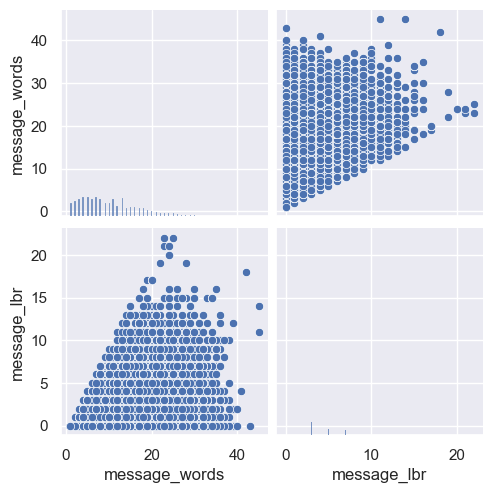

In [30]:
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_words', 'message_lbr']])
plt.show()

In [31]:
# g = sns.PairGrid(df[flt][['message_words', 'message_lbr']])
# g = g.map_upper(plt.scatter, marker='+')
# g = g.map_lower(sns.kdeplot, cmap="hot",fill=True)
# g = g.map_diag(sns.kdeplot, fill=True)


## 3. Análisis en series de tiempo

In [32]:
def create_word_bins(df, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 25, 30, 35, 40, 45, 50, np.inf]):
    """
    Function to bin the word count into categories.
    You can modify 'bins' based on your use case.
    """
    # Create a new column 'word_bin' based on the number of words
    df['word_bin'] = pd.cut(df['message_words'], bins=bins, labels=False, right=False)
    return df


# Similarities

In [34]:
sim_work_file = f"data/{base_name}_enhanced_sim.csv"
if os.path.exists(sim_work_file):
    print(f"File {sim_work_file} already exists. Loading it.")
    df_sim = pd.read_csv(sim_work_file)
    df_sim['date_source_posted_at'] = pd.to_datetime(df_sim['date_source_posted_at'])
else:
    df_sim = df.copy()
    df_sim.rename(columns={'message_lbr': 'message_lbr_utf8'}, inplace=True)
    df_sim.rename(columns={'message_words': 'message_words_utf8'}, inplace=True)

df_sim.info()

File data/signals_langs_enhanced_sim.csv already exists. Loading it.


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_11177/3576049643.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sim = pd.read_csv(sim_work_file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445265 entries, 0 to 445264
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       445265 non-null  int64              
 1   commodity                356095 non-null  object             
 2   source_posted_at         445265 non-null  object             
 3   trade_type               444798 non-null  object             
 4   chat_id                  445265 non-null  float64            
 5   telegram_user_id         445265 non-null  int64              
 6   message_text             445265 non-null  object             
 7   message_text_translated  1170 non-null    object             
 8   language                 445265 non-null  object             
 9   date_source_posted_at    445265 non-null  datetime64[ns, UTC]
 10  message_text_clean       445265 non-null  object             
 11  message_encod

## additional cleanup

In [35]:
# Instalación de las bibliotecas necesarias
import os
import nltk
import spacy
import pandas as pd
import re
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [36]:
from dateutil.parser import parse

def is_date(string): # NEEDS MORE WORK
    try:
        # Try to parse the string as a date
        parse(string, fuzzy=False)
        return True
    except ValueError:
        return False
    except Exception as e:
        print(f"Error checking date with: {string}")
        print(e)
        return False

def is_number(string):
    try:
        float(string)  # Try to convert to float
        return True
    except ValueError:
        return False
    except Exception as e:
        print(f"Error checking number with: {string}")
        print(e)
        return False


stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess(text, stop_words=stop_words):

    text = text.lower()
    # tokenizar el texto
    text = text.replace('\n', ' LBRMARK ')

    
    text_tokens = word_tokenize(text)
    # replace numbers with a placeholder
    # print(text_tokens)
    text_tokens_rst = text_tokens.copy() 
    i = -1
    for token in text_tokens:
        i += 1
        token = re.sub(r'\s+', ' ', token)

        # if token in stop_words:
        #     # remove the token from the list
        #     text_tokens_rst.pop(i)
        #     i -= 1
        #     # text_tokens_rst[i] = '{STOP_WORD}'
        #     continue

        if is_number(token):
            text_tokens_rst[i] = '{NUM}'
            continue

        if is_date(token):
            text_tokens_rst[i] = '{DATE}'
            continue

        tmp_token = re.sub(r'[^a-zA-Z0-9@\s]', ' ', token)  # eliminar caracteres especiales
        if tmp_token == token:
            continue
        text_tokens_rst[i] = preprocess(tmp_token)

    text = ' '.join(text_tokens_rst)
    # print(text)

    # text = re.sub(r'[^a-zA-Z0-9@\s]', ' ', text)  # eliminar caracteres especiales
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # print(text)

    text = text.replace(' LBRMARK ', '\n')
    text = text.replace('LBRMARK', '\n')
    text = clean_lbr(text)
    return text


# df['tokenized_nltk'] = df['cleaned'].apply(word_tokenize)

# aclarar que se usa un dataset expandido
# Evolucion temporal con los meses con más mensajes
# conteo de users y chat_ids
# Mensajes por tipo de operación




In [164]:
force_process = True
# sim_work_file = f"data/{base_name}_enhanced_sim.csv"
if 'cleaned_sim' not in df_sim.columns or force_process :
    print("Cleaning messages")
    # # apply preprocess to the messages df_sim['message_text_clean_utf8']
    df_sim['cleaned_sim'] = df_sim['message_text_clean_utf8'].apply(preprocess)

    # Añadir columna con el número de palabras
    print("Checking message words")
    df_sim['message_words'] = df_sim['cleaned_sim'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df_sim['message_lbr'] = df_sim['cleaned_sim'].parallel_apply(count_line_breaks)

    print("Creating word bins")
    df_sim = create_word_bins(df_sim)

    print("Store the processed data")
    df_sim.to_csv(sim_work_file, index=False)


Cleaning messages
Error checking date with: 6114172758m
signed integer is greater than maximum
Error checking date with: 6006491614109629746:0708
signed integer is greater than maximum
Error checking date with: 6006491614097847730:7917
signed integer is greater than maximum
Error checking date with: 6006491614115473931:3890
signed integer is greater than maximum
Error checking date with: 6006491614078897142:7516
signed integer is greater than maximum
Error checking date with: 6006491614089677384:9177
signed integer is greater than maximum
Error checking date with: 6006491614102651200:8747
signed integer is greater than maximum
Error checking date with: 6006491614084973804:5433
signed integer is greater than maximum
Error checking date with: 6006491614098519775:8573
signed integer is greater than maximum
Error checking date with: 6006491614098254910:0608
signed integer is greater than maximum
Error checking date with: 6006491614096392704:7889
signed integer is greater than maximum
Error

In [165]:
df_sim.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445265 entries, 0 to 445264
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       445265 non-null  int64              
 1   commodity                356095 non-null  object             
 2   source_posted_at         445265 non-null  object             
 3   trade_type               444798 non-null  object             
 4   chat_id                  445265 non-null  float64            
 5   telegram_user_id         445265 non-null  int64              
 6   message_text             445265 non-null  object             
 7   message_text_translated  1170 non-null    object             
 8   language                 445265 non-null  object             
 9   date_source_posted_at    445265 non-null  datetime64[ns, UTC]
 10  message_text_clean       445265 non-null  object             
 11  message_encod

## Groups to analize

Vamos a revisar los mensajes por grupos que compartan message_lbr', 'word_bin y trade_type

In [167]:
def gen_groups(df_msg):
# def gen_groups(df, group_cols):
    df_grouped = None
    print("Grouping")
    # df_grouped = df_sim.groupby([group_cols], dropna=False)
    df_grouped = df_msg.groupby(['message_lbr', 'word_bin', 'trade_type'], dropna=False)
    # transform the groupby object to a DataFrame
    df_grouped = df_grouped.size().reset_index(name='count')


    # replace NA values in commodity  wiht {Not Specified}
    df_grouped['trade_type'] = df_grouped['trade_type'].fillna('{Not Specified}')

    # sort df_grouped by count
    df_grouped = df_grouped.sort_values(by='count', ascending=False)

    return df_grouped

df_grouped = gen_groups(df_sim)

# print df_grouped size
print(f"Number of rows in df_grouped: {df_grouped.shape[0]}")

grp_min_size = 10
flt = df_grouped['count'] > grp_min_size
df_grouped2 = df_grouped[flt]

print(f"Number of rows in df_grouped filter by size > {grp_min_size}: {df_grouped2.shape[0]}")


Grouping
Number of rows in df_grouped: 1084
Number of rows in df_grouped filter by size > 10: 704


In [168]:
df_grouped2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 704 entries, 16 to 661
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   message_lbr  704 non-null    int64 
 1   word_bin     704 non-null    int64 
 2   trade_type   704 non-null    object
 3   count        704 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 27.5+ KB


## Compare list

Para determinar que mensajes vamos a comparar, vamos a procesarlos por una ventana de tiempo, en la que un mesaje se comparara con los otros de su grupo dentro de esa ventana. La ventana se define con el inicio del mensaje a comparar y un tamaño de ventana en días.

Por ejemplo si la ventana es de 7 días se compararia un mensaje con los que esten dentro de los siguientes 7 días a partir de la fecha del mensaje, esto dentro del grupo al que el mensaje pertenece.


In [191]:
# buid compare list per groups

def build_compare_list(df_grouped, window_size):
    # loop over df_grouped
    results = []
    ctrl_duplicated = {}
    tokenization = {}
    # msg_fld = 'message_text_clean_utf8'
    # window_size = 7

    # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # mdl = BertModel.from_pretrained('bert-base-uncased')

    # for idx, row in df_grouped2.head(1).iterrows():
    for idx, row in df_grouped.iterrows():
        # print the row
        message_lbr= row['message_lbr']
        word_bin= row['word_bin']
        trade_type= row['trade_type']
        count= row['count']
        
        print(f"message_lbr: {message_lbr}, word_bin: {word_bin}, trade_type: {trade_type}, count: {count}")

        # filter df by message_lbr, word_bin and commodity 
        if trade_type == '{Not Specified}':
            flt = (df_sim['message_lbr'] == message_lbr) & (df_sim['word_bin'] == word_bin) & df_sim['trade_type'].isnull()
        else:
            flt = (df_sim['message_lbr'] == message_lbr) & (df_sim['word_bin'] == word_bin) & (df_sim['trade_type'] == trade_type)
        
        # also filter by chat_id not in the group
        
        grp_src = df_sim[flt][['id_msg', 'chat_id', 'date_source_posted_at']].sort_values(by='date_source_posted_at')
        
        
        # loop over grp_src
        for idx_src, row2 in grp_src.iterrows():
            # print the row
            id_src= row2['id_msg']
            chat_id = row2['chat_id']
            date_source_posted_at_src= row2['date_source_posted_at']
            # print(f"    id: {idx_src}, date_source_posted_at: {date_source_posted_at_src}")
            # define the slinding window
            window_start = date_source_posted_at_src
            window_end = window_start + pd.Timedelta(days=window_size)
            
            sliding_window_flt = (grp_src['date_source_posted_at'] >= window_start) &  (grp_src['date_source_posted_at'] <= window_end)
            sliding_window_flt = sliding_window_flt & (grp_src['chat_id'] != chat_id)
            
            # Select all rows in the same sub-group that are within the 7-day window
            df_sliding_window = grp_src[sliding_window_flt]
            # print the number of rows in the sliding window
            # print(f"        Number of rows in the sliding window: {df_sliding_window.shape[0]}")
            # Iterate ove the sliding window to print the id and date_source_posted_at

            for idx_comp, row3 in df_sliding_window.iterrows():
                id_comp= row3['id_msg']
                if id_src == id_comp:
                    # tokenization[id_src] =  get_bert_embedding(row3[msg_fld], tokenizer, mdl)
                    continue
                if id_comp in ctrl_duplicated and id_src == ctrl_duplicated[idx_comp]:
                    continue
                
                # if id_comp not in tokenization:
                #     tokenization[id_comp] =  get_bert_embedding(row3[msg_fld], tokenizer, mdl)
                # similarity = cosine(tokenization[id_src], tokenization[id_comp])

                ctrl_duplicated[id_src] = id_comp
                date_source_posted_at_comp= row3['date_source_posted_at']
                # print(f"            id_src: {id_src}, date_source_posted_at: {date_source_posted_at}")
                # print(f"            id_comp: {id_comp}, date_source_posted_at: {date_source_posted_at_comp}")
                # print("---------")
                results.append({
                    'message_lbr': message_lbr,
                    'word_bin': word_bin,
                    'trade_type': trade_type,
                    'id_1': idx_src,
                    'id_2': idx_comp,
                    'date_id_1': date_source_posted_at_src,
                    'date_id_2': date_source_posted_at_comp,
                    # 'similarity': similarity,
                    # 'distance': 1 - similarity
                    })

    df_results = pd.DataFrame(results)
    return df_results




In [182]:
# filter message_lbr > 0 and word_bin > 
flt = (df_grouped2['message_lbr'] > 0) 
df_grouped2 = df_grouped2[flt]

df_grouped2

,message_lbr,word_bin,trade_type,count
159,2,12,sell,4367
651,17,20,sell,3630
634,16,20,sell,3398
258,4,11,sell,3379
615,15,20,sell,3177
...,...,...,...,...
252,4,9,sell,11
860,51,20,buy,11
251,4,9,buy,11
658,18,18,buy,11


In [193]:
# Generate a comparison list
window_size = 5
df_results = build_compare_list(df_grouped2.head(2), window_size)

df_results

message_lbr: 2, word_bin: 12, trade_type: sell, count: 4367
message_lbr: 17, word_bin: 20, trade_type: sell, count: 3630


,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2
0,2,12,sell,177160,397100,2022-01-01 05:49:40+00:00,2022-01-01 17:08:50+00:00
1,2,12,sell,177160,64389,2022-01-01 05:49:40+00:00,2022-01-02 17:02:03+00:00
2,2,12,sell,177160,14512,2022-01-01 05:49:40+00:00,2022-01-04 14:05:27+00:00
3,2,12,sell,177160,326286,2022-01-01 05:49:40+00:00,2022-01-05 15:37:15+00:00
4,2,12,sell,177161,397100,2022-01-01 10:04:32+00:00,2022-01-01 17:08:50+00:00
...,...,...,...,...,...,...,...
178595,17,20,sell,56807,154757,2022-12-29 02:19:52+00:00,2022-12-30 13:19:15+00:00
178596,17,20,sell,56807,154790,2022-12-29 02:19:52+00:00,2022-12-30 14:22:59+00:00
178597,17,20,sell,56807,154924,2022-12-29 02:19:52+00:00,2022-12-30 21:00:44+00:00
178598,17,20,sell,56807,154927,2022-12-29 02:19:52+00:00,2022-12-30 21:01:32+00:00


In [135]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461177 entries, 0 to 461176
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   message_lbr  461177 non-null  int64              
 1   word_bin     461177 non-null  int64              
 2   trade_type   461177 non-null  object             
 3   id_1         461177 non-null  int64              
 4   id_2         461177 non-null  int64              
 5   date_id_1    461177 non-null  datetime64[ns, UTC]
 6   date_id_2    461177 non-null  datetime64[ns, UTC]
 7   similarity   461177 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(1), int64(4), object(1)
memory usage: 28.1+ MB


In [44]:
# save the results to a file
# df_results.to_csv('data/similarity_list.csv', index=False)

In [194]:
# count the number of rows in df_results per month  
monthly_counts = df_results.groupby(df_results['date_id_1'].dt.to_period('M')).size()
monthly_counts

# df_results['month'] = df_results['date_id_1'].dt.to_period('M')
# df_results['month'] = df_results['month'].dt.to_timestamp()
# df_results = df_results.sort_values(by='month')
# df_results_grouped = df_results.groupby('month').size().reset_index(name='count')


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_11177/3924232209.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df_results.groupby(df_results['date_id_1'].dt.to_period('M')).size()


date_id_1
2022-01    16960
2022-02     3982
2022-03    11245
2022-04     7848
2022-05     4483
           ...  
2022-08    53453
2022-09    23173
2022-10    28854
2022-11    11379
2022-12     1955
Freq: M, Length: 12, dtype: int64

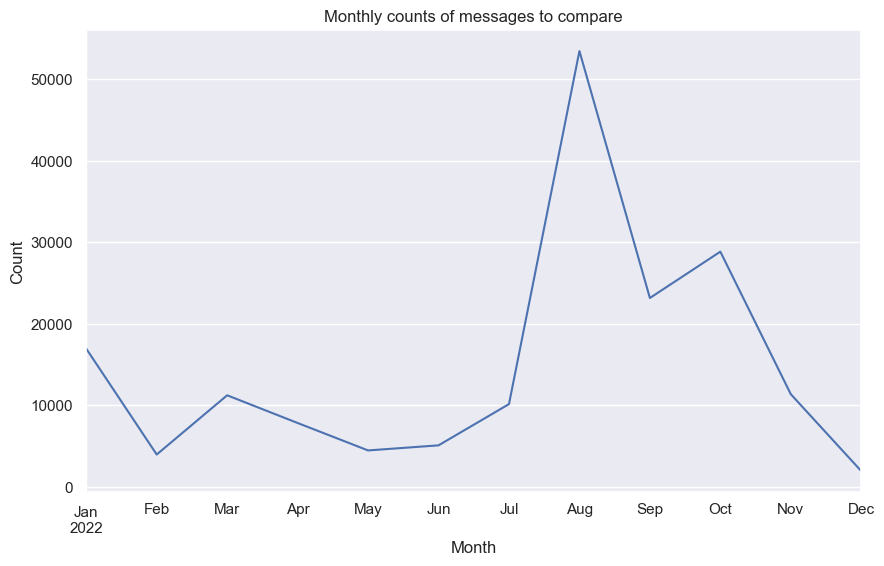

In [195]:
# plot monthly_counts
fig, ax = plt.subplots(figsize=(10, 6))
monthly_counts.plot(ax=ax)
ax.set_title('Monthly counts of messages to compare')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.show()


## Generate similarity matrix

### bert approach

### TFIDF approach

In [196]:
df_sim.shape

(445265, 21)

In [48]:
cols = ['id_msg', 'message_text_clean_utf8', 'cleaned_sim']
df_sim[cols].head(10)


,id_msg,message_text_clean_utf8,cleaned_sim
0,0,alts market is crashing badly and btc is runni...,alts market is crashing badly and btc is runni...
1,1,alts market is crashing badly and btc is runni...,alts market is crashing badly and btc is runni...
2,2,stay tuned,stay tuned
3,3,stay tuned,stay tuned
4,4,#oax (binance)\nbuy 510-530\nsell 578-629-680-...,oax binance\nbuy {NUM} {NUM}\nsell {NUM} {NUM}...
5,5,#oax (binance)\nbuy 510-530\nsell 578-629-680-...,oax binance\nbuy {NUM} {NUM}\nsell {NUM} {NUM}...
6,6,all of our targets achieved.\naround 270% quic...,all of our targets achieved\naround {NUM} quic...
7,7,all of our targets achieved.\naround 270% quic...,all of our targets achieved\naround {NUM} quic...
8,8,btsusdt first target met\ntill now +100% prof...,btsusdt first target met\ntill now {NUM} profi...
9,9,btsusdt first target met\ntill now +100% prof...,btsusdt first target met\ntill now {NUM} profi...


In [49]:
#filter df_results for jan, feb and mar
# flt = df_results['date_id_1'].dt.month.isin([1, 2, 3])
# flt = df_results['date_id_1'].dt.month.isin([6])
# df_results_jan_mar = df_results[flt]
# df_results_jan_mar = df_results_jan_mar.head(10000)
# df_results_jan_mar.shape

(4370, 7)

In [197]:
tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['message_text_clean_utf8'])
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])


In [ ]:
# # finde rows with message == stay tuned
# flt = df_sim['message_text_clean_utf8'] == 'stay tuned'

# tes_list = list(df_sim[cols].head(10).itertuples(index=False, name=None))

# # loop over df_results
# # for idx, row in df_sim[flt][cols].head(10).iterrows():
# for row in tes_list:
#     # print the row
#     idx, msg, msg_comp = row
#     print("#########")
#     print("---- row ----")
#     idx2 = idx + 1 
#     msg2 = tes_list[idx2][1]
#     msg_comp2 = tes_list[idx2][2]
#     print(idx, idx2)
#     print(msg_comp)
#     print("---------")
#     print(msg_comp2)
    
#     # print(tfidf_matrix[idx1])
#     # print(tfidf_matrix[idx1] == tfidf_matrix[idx2])
#     print(np.alltrue(tfidf_matrix[idx].toarray() == tfidf_matrix[idx2].toarray()))
#     sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix[idx2])
#     print(f"SIM: {sim[0][0]}")
#     print("#########")
#     print()


In [199]:
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])
# id_to_index = {idx: i for i, idx in enumerate(df_sim['id_msg'])}
# df_comp = df_results[['id_1', 'id_2']].head(200000)

In [ ]:
# from time import time

# # Generate tfidf_matrix


# similarities = []
# start = time()

# for _, row in df_comp.iterrows():
#     id1, id2 = row['id_1'], row['id_2']
    
#     # Get the indices of the messages in the TF-IDF matrix
#     print("#########")
#     idx1, idx2 = id_to_index[id1], id_to_index[id2]
#     print(f"idx1({id1}): {idx1}, idx2(id2): {idx2}")
#     # print df_sim messages
#     print(df_sim.loc[idx1, 'cleaned_sim'])
#     print(df_sim.loc[idx2, 'cleaned_sim'])
    

#     # print(tfidf_matrix[idx1])
#     # print(tfidf_matrix[idx2])

#     # Compute cosine similarity for the pair
#     print(np.alltrue(tfidf_matrix[idx].toarray() == tfidf_matrix[idx2].toarray()))
#     sim = cosine_similarity(tfidf_matrix[idx1], tfidf_matrix[idx2])[0][0]
#     print(f"SIM: {sim}")
#     # break
#     # Append the similarity result
#     similarities.append(sim)
#     print("#########")
#     print()

# # Add the similarities to df_comp
# df_comp['similarity'] = similarities

# end = time()
# elpased = end - start

# # Output the df_comp with similarities
# print(df_comp)

# # print df_comp total number of rows, df_results total number of rows, and the percentage of df_comp
# print(f"Number of rows in df_comp: {df_comp.shape[0]}")
# print(f"Number of rows in df_results: {df_results.shape[0]}")
# print(f"Percentage of df_comp: {df_comp.shape[0]/df_results.shape[0]:.2%}")

# # print the time it took to run the code
# print(f"Time taken: {elpased:.2f} seconds")
# # print number of rows per second
# print(f"Number of rows per second: {df_comp.shape[0]/elpased:.2f}")

# # Extrapolate the time to run the code for the entire df_results
# # print the time it would take to run the code for the entire df_results
# print(f"Estimated time for the entire df_results: {df_results.shape[0]/df_comp.shape[0]*elpased:.2f} seconds")


In [205]:
# df_comp_tmp = df_comp.head(200000).copy()
# df_comp_tmp['similarity'] = similarities


In [ ]:
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])
# id_to_index = {idx: i for i, idx in enumerate(df_sim['id_msg'])}
# df_comp = df_results[['id_1', 'id_2']].head(200000)

In [198]:
# inpunts:
# df_comp: DataFrame with the pairs of messages to compare
# tfidf_matrix: matix with the tfidf values for each message of the whole corpus - reindexed by id_msg
# id_to_index: dictionary with the index of the message in the tfidf_matrix

# output:
# - similarities2 - list with the similarities between the pairs of messages

from time import time
from joblib import Parallel, delayed
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Parallelized function to compute cosine similarity for a chunk of data
def compute_similarity_chunk(chunk, id_to_index, tfidf_matrix):
    similarities = []
    for _, row in chunk.iterrows():
        id1, id2 = row['id_1'], row['id_2']
        
        # Get the indices of the messages in the TF-IDF matrix
        idx1, idx2 = id_to_index[id1], id_to_index[id2]
        
        # Compute cosine similarity for the pair
        sim = cosine_similarity(tfidf_matrix[idx1], tfidf_matrix[idx2])[0][0]
        
        # Append the similarity result
        similarities.append(sim)
    return similarities

# Function to split dataframe into chunks
def split_dataframe(df, chunk_size):
    num_chunks = math.ceil(len(df) / chunk_size)
    return [df[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]


def get_similarities(df_comp, tfidf_matrix, df_sim):
    # Assume df_sim contains: id_msg, cleaned_sim (cleaned messages)
    # Assume df_results contains: id_1, id_2 (pairs of message IDs)

    # df_comp = df_results_jan_mar[['id_1', 'id_2']] 

    # Generate tfidf_matrix
    # tfidf_vectorizer = TfidfVectorizer()
    # tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])
    id_to_index = {idx: i for i, idx in enumerate(df_sim['id_msg'])}

    # Set the chunk size and number of parallel jobs (cores)
    chunk_size = 10000  # You can adjust this depending on your system's memory
    n_jobs = -1  # Use all available cores (-1 means using all cores)

    # Split df_comp into chunks
    chunks = split_dataframe(df_comp, chunk_size)

    # Measure start time
    start = time()

    # Parallel computation
    results = Parallel(n_jobs=n_jobs)(delayed(compute_similarity_chunk)(chunk, id_to_index, tfidf_matrix) for chunk in chunks)

    # Flatten the results into a single list
    similarities = [sim for chunk_sims in results for sim in chunk_sims]

    end = time()
    elapsed = end - start

    return similarities


# Add the similarities to df_comp
# df_comp['similarity'] = similarities2

# Measure end time

# Output the df_comp with similarities
# print(df_comp)

# # Print total number of rows, percentage, and performance stats
# print(f"Number of rows in df_comp: {df_comp.shape[0]}")
# print(f"Number of rows in df_results: {df_results.shape[0]}")
# print(f"Percentage of df_comp: {df_comp.shape[0]/df_results.shape[0]:.2%}")
# print(f"Time taken: {elapsed:.2f} seconds")
# print(f"Number of rows per second: {df_comp.shape[0]/elapsed:.2f}")

# # Extrapolate the time to run the code for the entire df_results
# estimated_time = df_results.shape[0] / df_comp.shape[0] * elapsed
# print(f"Estimated time for the entire df_results: {estimated_time:.2f} seconds")


In [199]:

df_comp = df_results
df_comp['similarity'] = get_similarities(df_comp, tfidf_matrix, df_sim)



In [200]:
#sort df_comp by similarity
df_comp_sorted = df_comp.sort_values(by='similarity', ascending=False)

In [201]:
df_comp_sorted

,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2,similarity
72191,2,12,sell,213165,214281,2022-08-26 11:12:00+00:00,2022-08-27 04:59:03+00:00,1.0
116645,17,20,sell,405150,226799,2022-09-22 00:19:25+00:00,2022-09-24 10:02:43+00:00,1.0
114344,17,20,sell,404850,226799,2022-09-19 12:13:19+00:00,2022-09-24 10:02:43+00:00,1.0
124072,17,20,sell,405672,227048,2022-09-24 13:52:45+00:00,2022-09-27 01:31:08+00:00,1.0
124066,17,20,sell,405672,227017,2022-09-24 13:52:45+00:00,2022-09-26 16:46:16+00:00,1.0
...,...,...,...,...,...,...,...,...
34013,2,12,sell,183021,208755,2022-08-12 17:01:22+00:00,2022-08-13 20:11:13+00:00,0.0
34012,2,12,sell,183020,390124,2022-08-12 16:56:50+00:00,2022-08-17 10:46:04+00:00,0.0
34011,2,12,sell,183020,299374,2022-08-12 16:56:50+00:00,2022-08-16 10:00:00+00:00,0.0
34010,2,12,sell,183020,208755,2022-08-12 16:56:50+00:00,2022-08-13 20:11:13+00:00,0.0


In [ ]:
# # filter df_comp_sorted by similarity < 0.9
# df_comp_sorted = df_comp.sort_values(by='similarity', ascending=False)
# flt = ( df_comp['distance'] < 0.4 ) & (df_comp['distance'] > 0.2)
# df_comp_sorted[flt]


In [202]:
df_comp.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178600 entries, 0 to 178599
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   message_lbr  178600 non-null  int64              
 1   word_bin     178600 non-null  int64              
 2   trade_type   178600 non-null  object             
 3   id_1         178600 non-null  int64              
 4   id_2         178600 non-null  int64              
 5   date_id_1    178600 non-null  datetime64[ns, UTC]
 6   date_id_2    178600 non-null  datetime64[ns, UTC]
 7   similarity   178600 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(1), int64(4), object(1)
memory usage: 10.9+ MB


In [203]:
def enrich_similarities(df_comp, df_sim):
    # get the messages with the ids in the df_comp using joins not changing index in the df_sim
    df_comp['id_1'] = df_comp['id_1'].astype(int)
    df_comp['id_2'] = df_comp['id_2'].astype(int)

    # drop the columns if they exist
    if 'message_text_clean_utf8_1' in df_comp.columns:
        df_comp = df_comp.drop(columns=['message_text_clean_utf8_1'])
    if 'message_text_clean_utf8_2' in df_comp.columns:
        df_comp = df_comp.drop(columns=['message_text_clean_utf8_2'])
    if 'cleaned_sim_1' in df_comp.columns:
        df_comp = df_comp.drop(columns=['cleaned_sim_1'])
    if 'cleaned_sim_2' in df_comp.columns:
        df_comp = df_comp.drop(columns=['cleaned_sim_2'])
        
    # Merge the df_comp with the df_sim to get the message text for the pairs of messages
    df_comp = df_comp.merge(df_sim[['id_msg','message_text_clean_utf8', 'cleaned_sim']], left_on='id_1', right_on='id_msg', 
                            how='left')
    df_comp = df_comp.rename(columns={'message_text_clean_utf8': 'message_text_clean_utf8_1', 
                                    'cleaned_sim': 'cleaned_sim_1'})
    df_comp = df_comp.drop(columns=['id_msg'])


    df_comp = df_comp.merge(df_sim[['id_msg','message_text_clean_utf8', 'cleaned_sim']], left_on='id_2', right_on='id_msg', 
                            how='left')
    df_comp = df_comp.rename(columns={'message_text_clean_utf8': 'message_text_clean_utf8_2', 
                                    'cleaned_sim': 'cleaned_sim_2'})
    df_comp = df_comp.drop(columns=['id_msg'])

    df_comp['distance'] = 1 - df_comp['similarity']
    return df_comp


# df_comp.head(10)
df_comp = enrich_similarities(df_comp, df_sim)
df_comp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178600 entries, 0 to 178599
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   message_lbr                178600 non-null  int64              
 1   word_bin                   178600 non-null  int64              
 2   trade_type                 178600 non-null  object             
 3   id_1                       178600 non-null  int64              
 4   id_2                       178600 non-null  int64              
 5   date_id_1                  178600 non-null  datetime64[ns, UTC]
 6   date_id_2                  178600 non-null  datetime64[ns, UTC]
 7   similarity                 178600 non-null  float64            
 8   message_text_clean_utf8_1  178600 non-null  object             
 9   cleaned_sim_1              178600 non-null  object             
 10  message_text_clean_utf8_2  178600 non-null  object      

In [57]:
df_comp.head()

,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,message_text_clean_utf8_2,cleaned_sim_2,distance
0,0,2,sell,390245,441477,2022-01-01 12:36:50+00:00,2022-01-01 12:45:09+00:00,0.000000,thank you boss,thank you boss,carvana tap in now !,carvana tap in now,1.000000
1,0,2,sell,390245,390246,2022-01-01 12:36:50+00:00,2022-01-01 13:22:35+00:00,0.584619,thank you boss,thank you boss,thanks boss,thanks boss,0.415381
2,0,2,sell,441477,390246,2022-01-01 12:45:09+00:00,2022-01-01 13:22:35+00:00,0.000000,carvana tap in now !,carvana tap in now,thanks boss,thanks boss,1.000000
3,0,2,sell,289827,310017,2022-01-01 16:35:48+00:00,2022-01-01 16:44:49+00:00,0.000000,@treasurydeptllc,@ treasurydeptllc,clear your tg,clear your tg,1.000000
4,0,2,sell,289827,390253,2022-01-01 16:35:48+00:00,2022-01-01 17:08:38+00:00,0.000000,@treasurydeptllc,@ treasurydeptllc,18 months,{NUM} months,1.000000


In [131]:
# drop the columns id_msg_x and id_msg_y
# df_comp = df_comp.drop(columns=['cleaned_sim_1', 'message_text_clean_utf8_1'])


## Clustering messages

### Matriz de distancias

In [147]:
def get_labels_groups(labels, id_list=None):
    ''''
    Function to get the groups of messages based on the labels
    labels: list of labels received from the clustering algorithm AgglomerativeClustering
    [1,2,3,2,2,1] -> {1: [0, 5], 2: [1, 3, 4], 3: [2]}
    and with id_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    -> {1: [10, 60], 2: [20, 40, 50], 3: [30]}
    
    By default, the function will use the index as the id
    If id_list is provided, the function will use the id_list to get the id
    in the index position
    '''
    positions_dict = {}
    if id_list is not None:
        def get_id(index):
            return id_list[index]
    else:
        def get_id(index):
            return index

    for index, value in enumerate(labels):
        id = get_id(index)
        if value in positions_dict:
            positions_dict[value].append(id)
        else:
            positions_dict[value] = [id]
    return positions_dict


In [207]:
df_comp_flt = df_comp
# filter the df_comp by distance > 0.5
flt = (df_comp_flt['distance'] < 0.4)  & (df_comp_flt['distance'] > 0.0)
df_comp_flt = df_comp_flt[flt]    
df_comp_flt


,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,message_text_clean_utf8_2,cleaned_sim_2,distance
29626,2,12,sell,105785,105332,2022-07-25 17:50:15+00:00,2022-07-28 16:24:42+00:00,0.900420,"binance futures, bybit usdt, kucoin futures, o...",binance futures bybit usdt kucoin futures okx ...,"binance futures, bybit usdt, kucoin futures, o...",binance futures bybit usdt kucoin futures okx ...,0.099580
29658,2,12,sell,105785,105337,2022-07-25 17:50:15+00:00,2022-07-29 16:39:03+00:00,0.762132,"binance futures, bybit usdt, kucoin futures, o...",binance futures bybit usdt kucoin futures okx ...,"binance futures, bybit usdt, kucoin futures\n#...",binance futures bybit usdt kucoin futures\noce...,0.237868
35354,2,12,sell,187467,3272,2022-08-21 16:18:51+00:00,2022-08-25 19:00:32+00:00,0.887959,"kucoin, binance, huobi.pro, bittrex\n#band/usd...",kucoin binance huobi pro bittrex\nband usdt al...,"kucoin, huobi.pro, bittrex, binance\n#ltc/usdt...",kucoin huobi pro bittrex binance\nltc usdt all...,0.112041
35355,2,12,sell,187467,3271,2022-08-21 16:18:51+00:00,2022-08-25 19:00:32+00:00,0.887959,"kucoin, binance, huobi.pro, bittrex\n#band/usd...",kucoin binance huobi pro bittrex\nband usdt al...,"kucoin, huobi.pro, bittrex, binance\n#ltc/usdt...",kucoin huobi pro bittrex binance\nltc usdt all...,0.112041
35397,2,12,sell,187467,3303,2022-08-21 16:18:51+00:00,2022-08-25 19:17:11+00:00,0.887959,"kucoin, binance, huobi.pro, bittrex\n#band/usd...",kucoin binance huobi pro bittrex\nband usdt al...,"kucoin, huobi.pro, bittrex, binance\n#ltc/usdt...",kucoin huobi pro bittrex binance\nltc usdt all...,0.112041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147026,17,20,sell,229441,115180,2022-10-06 02:54:52+00:00,2022-10-10 08:48:36+00:00,0.604308,high balance paypal accounts\nuse money immedi...,high balance paypal accounts\nuse money immedi...,coinbase accounts (no 2fa)\nwithdraw crypto im...,coinbase accounts no 2fa\nwithdraw crypto imme...,0.395692
147028,17,20,sell,229441,115225,2022-10-06 02:54:52+00:00,2022-10-10 12:05:41+00:00,0.604308,high balance paypal accounts\nuse money immedi...,high balance paypal accounts\nuse money immedi...,coinbase accounts (no 2fa)\nwithdraw crypto im...,coinbase accounts no 2fa\nwithdraw crypto imme...,0.395692
147034,17,20,sell,229441,115364,2022-10-06 02:54:52+00:00,2022-10-10 22:06:33+00:00,0.604308,high balance paypal accounts\nuse money immedi...,high balance paypal accounts\nuse money immedi...,coinbase accounts (no 2fa)\nwithdraw crypto im...,coinbase accounts no 2fa\nwithdraw crypto imme...,0.395692
147040,17,20,sell,229441,115405,2022-10-06 02:54:52+00:00,2022-10-10 23:49:16+00:00,0.604308,high balance paypal accounts\nuse money immedi...,high balance paypal accounts\nuse money immedi...,coinbase accounts (no 2fa)\nwithdraw crypto im...,coinbase accounts no 2fa\nwithdraw crypto imme...,0.395692


In [70]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [128]:
ids = df_comp[['id_1', 'id_2']].values.ravel()
ids

array([390245, 441477, 390245, ..., 170418, 170418, 285042])

In [209]:
def init_similarity_dict(df_comp):
    # Get unique ids
    ids = pd.unique(df_comp[['id_1', 'id_2']].values.ravel())
    id_to_index = {id_val: i for i, id_val in enumerate(ids)}

    # Create row, column, and distance values
    row = [id_to_index[id1] for id1 in df_comp['id_1']]
    col = [id_to_index[id2] for id2 in df_comp['id_2']]
    distances = df_comp['similarity']

    # Create a sparse matrix in CSR format
    n = len(ids)  # Total number of unique ids
    sparse_matrix = csr_matrix((distances, (row, col)), shape=(n, n))

    # Since the matrix is symmetric, add the transpose to fill the lower triangle
    sparse_matrix = sparse_matrix + sparse_matrix.T
    return {'id_to_index': id_to_index,
            "ids": ids,
            "sim_matrix": sparse_matrix}



In [210]:
# similarity_dict = init_similarity_dict(df_comp)
similarity_dict = init_similarity_dict(df_comp_flt)

ValueError: all index and data arrays must have the same length

In [79]:
from sklearn.cluster import AgglomerativeClustering


In [120]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461177 entries, 0 to 461176
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   message_lbr                461177 non-null  int64              
 1   word_bin                   461177 non-null  int64              
 2   trade_type                 461177 non-null  object             
 3   id_1                       461177 non-null  int64              
 4   id_2                       461177 non-null  int64              
 5   date_id_1                  461177 non-null  datetime64[ns, UTC]
 6   date_id_2                  461177 non-null  datetime64[ns, UTC]
 7   similarity                 461177 non-null  float64            
 8   message_text_clean_utf8_1  461177 non-null  object             
 9   cleaned_sim_1              461177 non-null  object             
 10  message_text_clean_utf8_2  461177 non-null  object      

In [ ]:
# for each group of messages, get the clusters
# 1. get the labels
# 2. get the groups
# 3. get the messages in each group
# 4. get the messages in each cluster

# loop over the groups
# for each group, get the clusters


def gen_cluster(df_comp):
    # loop over df_grouped
    results = []
    ctrl_duplicated = {}
    tokenization = {}

    # group df_comp by message_lbr, word_bin and trade_type
    df_grouped = df_comp.groupby(['message_lbr', 'word_bin', 'trade_type'], dropna=False)
    # transform the groupby object to a DataFrame
    df_grouped = df_grouped.size().reset_index(name='count')
    
    labels = []
    # for idx, row in df_grouped2.head(1).iterrows():
    for idx, row in df_grouped.iterrows():
        # print the row
        message_lbr= row['message_lbr']
        word_bin= row['word_bin']
        trade_type= row['trade_type']
        count= row['count']
        print(f"message_lbr: {message_lbr}, word_bin: {word_bin}, trade_type: {trade_type}, count: {count}")

        # filter df by message_lbr, word_bin and commodity 
        if trade_type == '{Not Specified}':
            flt = (df_comp['message_lbr'] == message_lbr) & (df_comp['word_bin'] == word_bin) & df_comp['trade_type'].isnull()
        else:
            flt = (df_comp['message_lbr'] == message_lbr) & (df_comp['word_bin'] == word_bin) & (df_comp['trade_type'] == trade_type)
        
        grp_src = df_comp[flt]
        sim_matrix = init_similarity_matrix(grp_src)
        build_gpr = AgglomerativeClustering(metric='precomputed', linkage='complete', compute_full_tree=True, n_clusters=None, distance_threshold=0.5)
        print("distance_matrix")
        print(1- sim_matrix.toarray())
        cur_labels = build_gpr.fit_predict(1- sim_matrix.toarray())
        print(cur_labels)
        labels.append(cur_labels)
    df_grouped['labels'] = labels
    return labels, df_grouped

labels, df_grouped = gen_cluster(df_comp)
# clustering = AgglomerativeClustering(metric='precomputed', linkage='complete', compute_full_tree=True, n_clusters=None, distance_threshold=0.3)
# labels = clustering.fit_predict(distances)

# print("Labels:", labels)
# grps_cluster = get_labels_groups(labels)
# print(grps_cluster)

In [93]:
labels

[array([  158, 11928,   158, ...,   231,   390,  2756]),
 array([10182,  8956, 10181, ...,   103,   798,   588])]

In [88]:
df_grouped

,message_lbr,word_bin,trade_type,count,labels
0,0,2,sell,230448,"[73, 14, 37, 73, 14, 37, 42, 82, 44, 96, 36, 2..."
1,0,3,sell,230729,"[19, 118, 169, 19, 118, 169, 168, 147, 146, 14..."


In [154]:
build_gpr = AgglomerativeClustering(metric='precomputed', linkage='complete', compute_full_tree=True, n_clusters=None, distance_threshold=0.3)
cur_labels = build_gpr.fit_predict(1 - similarity_dict['sim_matrix'].toarray())

In [155]:
print(len(cur_labels))
# cur_labels
grps_cluster = get_labels_groups(cur_labels, similarity_dict['ids'])
grp_ids_cluster = [v for k, v in grps_cluster.items() if len(v) > 1]
grp_ids_cluster

490


[[15155, 15173],
 [326971, 326977],
 [327030, 263276],
 [263886, 263890],
 [317044, 317043, 317045],
 [317057, 317059],
 [17831, 17833],
 [17992, 17995, 18007],
 [330548, 330550],
 [19274, 19275],
 [391152, 391153],
 [318172, 20599],
 [318831, 318833],
 [393848, 393850],
 [394184, 394190],
 [24863, 24870],
 [208157, 213474],
 [2360, 210630],
 [207302, 2361],
 [203791, 203789],
 [212086, 2153],
 [2152, 210641],
 [209787, 214084],
 [8619, 307800],
 [200068, 206537],
 [300645, 353937],
 [206923, 209318],
 [207000, 209388],
 [210535, 207506],
 [339913, 339925],
 [355306, 355305],
 [341423, 273461],
 [342161, 321132],
 [342699, 342757],
 [342922, 342924],
 [350182, 350259],
 [362962, 362965],
 [34462, 34469],
 [352267, 352342],
 [164378, 164439],
 [352937, 352985],
 [411685, 411687],
 [36863, 36871],
 [367469, 367601],
 [37658, 37740],
 [412586, 412587],
 [368312, 368313],
 [413109, 413111],
 [413182, 413184],
 [413655, 413658],
 [413935, 413948],
 [277568, 369270],
 [370501, 370503],
 [278

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 2557 to 457364
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   message_lbr                412 non-null    int64              
 1   word_bin                   412 non-null    int64              
 2   trade_type                 412 non-null    object             
 3   id_1                       412 non-null    int64              
 4   id_2                       412 non-null    int64              
 5   date_id_1                  412 non-null    datetime64[ns, UTC]
 6   date_id_2                  412 non-null    datetime64[ns, UTC]
 7   similarity                 412 non-null    float64            
 8   message_text_clean_utf8_1  412 non-null    object             
 9   cleaned_sim_1              412 non-null    object             
 10  message_text_clean_utf8_2  412 non-null    object             
 11  clean

In [162]:
# Funcion para comparar los resultados de similitud para grupos de mensajes
def check_sim(grp_ids, sim_matrix_df_dict, messages_df, column="cleaned"):
  for grp in grp_ids:
    print("------")
    print(f"Grupo: {grp}")
    flt = messages_df["id_msg"].isin(grp)
    tmp_df = messages_df[flt].sort_values("id_msg")
    # loop over tmp_df to print the df row
    for idx, row in tmp_df.iterrows():
      print(f" --- msg_id: {row['id_msg']} ---")
      print(f"{row['message_lbr']} - {row['word_bin']} - {row['trade_type']}")
      print(f"{row[column]}")
      print(f"{row['message_text_clean_utf8']}")
      print(f" ----------")



    # for msg_id, msg in zip(tmp_df["id_msg"], tmp_df[column]):
    #   print(f" --- msg_id: {msg_id} ---")
    #   print(f"{msg}")
    #   print(f" ----------")
    print()
    combs = set([frozenset([id1, id2]) for id2 in grp for id1 in grp if id1 != id2])
    # get scores:
    for pair in combs:
      ids = list(pair)
      print(f"  Pair:   {ids}")
      for name, matrix in sim_matrix_df_dict.items():
        flt = (df_comp['id_1'] == ids[0]) & (df_comp['id_2'] == ids[1]) | (df_comp['id_1'] == ids[1]) & (df_comp['id_2'] == ids[0])
        distance_val = matrix[flt]['distance'].tolist()
        # get the value of matrix[flt]['distance'] to get the distance
        print(f"      {name} - {distance_val[0]}")

    print()


In [161]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445265 entries, 0 to 445264
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       445265 non-null  int64              
 1   commodity                356095 non-null  object             
 2   source_posted_at         445265 non-null  object             
 3   trade_type               444798 non-null  object             
 4   chat_id                  445265 non-null  float64            
 5   telegram_user_id         445265 non-null  int64              
 6   message_text             445265 non-null  object             
 7   message_text_translated  1170 non-null    object             
 8   language                 445265 non-null  object             
 9   date_source_posted_at    445265 non-null  datetime64[ns, UTC]
 10  message_text_clean       445265 non-null  object             
 11  message_encod

In [163]:
matrix_list = {
    "Cosine": df_comp,
}
check_sim(grp_ids_cluster, matrix_list, df_sim, 'cleaned_sim')

------
Grupo: [15155, 15173]
 --- msg_id: 15155 ---
0 - 2 - sell
it s a rug {NUM}
it's a rug 100%
 ----------
 --- msg_id: 15173 ---
0 - 2 - sell
this token is a rug
this token is a rug
 ----------

  Pair:   [15155, 15173]
      Cosine - 0.2564384025351175

------
Grupo: [326971, 326977]
 --- msg_id: 326971 ---
0 - 2 - sell
welcome anshul
welcome anshul!!
 ----------
 --- msg_id: 326977 ---
0 - 2 - sell
anshul arrived
anshul arrived
 ----------

  Pair:   [326977, 326971]
      Cosine - 0.26536736695937313

------
Grupo: [327030, 263276]
 --- msg_id: 263276 ---
0 - 2 - sell
english please
english please
 ----------
 --- msg_id: 327030 ---
0 - 2 - sell
english only please
english only please
 ----------

  Pair:   [263276, 327030]
      Cosine - 0.09282640058422076

------
Grupo: [263886, 263890]
 --- msg_id: 263886 ---
0 - 2 - sell
good morning
good morning
 ----------
 --- msg_id: 263890 ---
0 - 2 - sell
good morning all
good morning all
 ----------

  Pair:   [263890, 263886]
      

In [106]:
df_comp
# filter by id_1 and id_2   



,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,message_text_clean_utf8_2,cleaned_sim_2,distance
0,0,2,sell,390245,441477,2022-01-01 12:36:50+00:00,2022-01-01 12:45:09+00:00,0.000000,thank you boss,thank you boss,carvana tap in now !,carvana tap in now,1.000000
1,0,2,sell,390245,390246,2022-01-01 12:36:50+00:00,2022-01-01 13:22:35+00:00,0.584619,thank you boss,thank you boss,thanks boss,thanks boss,0.415381
2,0,2,sell,441477,390246,2022-01-01 12:45:09+00:00,2022-01-01 13:22:35+00:00,0.000000,carvana tap in now !,carvana tap in now,thanks boss,thanks boss,1.000000
3,0,2,sell,289827,310017,2022-01-01 16:35:48+00:00,2022-01-01 16:44:49+00:00,0.000000,@treasurydeptllc,@ treasurydeptllc,clear your tg,clear your tg,1.000000
4,0,2,sell,289827,390253,2022-01-01 16:35:48+00:00,2022-01-01 17:08:38+00:00,0.000000,@treasurydeptllc,@ treasurydeptllc,18 months,{NUM} months,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461172,0,3,sell,170401,170418,2022-12-30 21:00:33+00:00,2022-12-30 23:18:12+00:00,0.000000,caption: we're back baby!,caption we re back baby,"retardo, my currency is usdt",retardo my currency is usdt,1.000000
461173,0,3,sell,57388,170407,2022-12-30 21:01:21+00:00,2022-12-30 21:04:14+00:00,0.000000,yo thomas sup,yo thomas sup,"omg, what an idiot do we have in this group?",omg what an idiot do we have in this group,1.000000
461174,0,3,sell,57388,170418,2022-12-30 21:01:21+00:00,2022-12-30 23:18:12+00:00,0.000000,yo thomas sup,yo thomas sup,"retardo, my currency is usdt",retardo my currency is usdt,1.000000
461175,0,3,sell,170407,170418,2022-12-30 21:04:14+00:00,2022-12-30 23:18:12+00:00,0.000000,"omg, what an idiot do we have in this group?",omg what an idiot do we have in this group,"retardo, my currency is usdt",retardo my currency is usdt,1.000000


490


array([384, 222, 275, 252, 380, 232, 296, 307,   3,   3, 330, 297, 311,
       369,  15,  15,  84,  84, 366, 361, 280, 261, 402, 298, 294, 246,
       427, 263, 386, 429, 223, 351, 249, 278, 337, 431, 387, 425, 293,
       276, 299, 364, 417, 381, 399, 300, 265, 357, 401,  14,  14, 405,
       350, 391, 291, 285, 358, 398, 255, 242, 120, 120, 295, 345,  29,
        29,  28,  28, 348, 383, 236, 235, 234, 233,  57,  57, 231,   2,
       114,   2, 114, 228,  56,  56, 226,   6,   6, 224,  27,  27, 347,
       115, 221, 220, 346, 251, 218, 217, 216, 432, 172, 419, 344, 423,
       426, 363, 397, 421, 343, 108,  25,  25, 415, 413, 102,  50, 102,
        50, 407, 282, 268, 430, 219, 292, 240,  24,  24,   5,   5,  11,
        11, 146, 309, 215, 117,  47,  47, 178, 281, 308, 286, 354, 258,
       328, 147, 379, 377, 375, 373, 321, 270, 319, 367, 376, 327,   4,
         4, 181,  10,  10, 289, 349, 355, 269, 428, 394, 271, 262, 378,
       130, 187, 322, 310, 305, 174, 382,  20,  20,  41,  41, 28

In [315]:
ids = df_sim['id_msg'].to_list()
grps_cluster = get_labels_groups(labels, ids)
grp_ids_cluster = [v for k, v in grps_cluster.items() if len(v) > 1]

grp_ids_cluster

# get a list of the number of elements in each group
num_elements = [len(v) for v in grp_ids_cluster]
num_elements

[1139,
 1093,
 1492,
 1187,
 1171,
 1200,
 1363,
 1036,
 890,
 1044,
 938,
 661,
 965,
 875,
 616,
 344,
 368,
 908,
 981,
 839,
 662,
 598,
 934,
 886,
 564,
 375,
 374,
 346,
 586,
 481,
 434,
 249,
 745,
 488,
 488,
 601,
 450,
 229,
 498,
 599,
 224,
 230,
 463,
 492,
 629,
 258,
 538,
 585,
 276,
 272,
 698,
 285,
 851,
 728,
 264,
 275,
 512,
 500,
 536,
 260,
 245,
 541,
 217,
 988,
 289,
 240,
 230,
 241,
 436,
 516,
 492,
 697,
 464,
 290,
 473,
 476,
 466,
 226,
 262,
 280,
 510,
 226,
 502,
 235,
 484,
 221,
 284,
 544,
 218,
 257,
 560,
 264,
 274,
 303,
 211]

In [316]:
len(num_elements)

95

In [318]:
# len(num_elements)
grp_ids_cluster[94]


[10330,
 10353,
 10462,
 10553,
 10743,
 10944,
 11131,
 11295,
 11459,
 11636,
 11855,
 12032,
 12225,
 12399,
 12591,
 12779,
 12969,
 13154,
 13366,
 13591,
 13789,
 14014,
 14220,
 14407,
 14605,
 14772,
 14939,
 15115,
 15283,
 15451,
 15625,
 15798,
 15974,
 16282,
 16741,
 17056,
 17418,
 17922,
 18198,
 18199,
 18200,
 18201,
 18202,
 18505,
 18714,
 18957,
 19211,
 19413,
 19609,
 19843,
 20027,
 20360,
 20622,
 20798,
 21032,
 21215,
 21471,
 21667,
 21871,
 22254,
 22506,
 22729,
 22921,
 23205,
 23377,
 23675,
 23907,
 23908,
 24367,
 24616,
 25101,
 25320,
 25575,
 25929,
 26107,
 26276,
 26277,
 26278,
 26279,
 26281,
 26282,
 26283,
 26285,
 26286,
 26287,
 26288,
 26564,
 26751,
 26966,
 27234,
 27492,
 27694,
 27879,
 28054,
 28286,
 28451,
 28615,
 28779,
 28944,
 29189,
 29190,
 29191,
 29200,
 29201,
 29202,
 29203,
 29204,
 29205,
 29206,
 29422,
 29683,
 30354,
 30355,
 30713,
 30890,
 31057,
 31262,
 31263,
 31507,
 31831,
 32069,
 32286,
 33088,
 33271,
 33609,


In [319]:
# get the messages with ids in [7578, 7791, 8003, 8210, 8417, 8622, 8827, 9032, 9238, 9441, 9645, 9850, 10053, 10256, 10459,  10662]
# grp_ids_cluster[203]
df_sim[df_sim['id_msg'].isin(grp_ids_cluster[94])][['id_msg', 'message_text_clean_utf8', 'cleaned_sim']]



,id_msg,message_text_clean_utf8,cleaned_sim
10330,10330,we are providing whale's vip channel for fre...,we are providing whale s vip channel for free\...
10353,10353,don't miss guy's,do n t miss guy s
10462,10462,binance futures\n#dydx/usdt entry target 1\nav...,binance futures\ndydx usdt entry target {NUM}\...
10553,10553,from 350 usdt you get back about 1.2k usdt!,from {NUM} usdt you get back about {NUM} 2k usdt
10743,10743,merry christmas to all of you,merry christmas to all of you
...,...,...,...
51194,51194,"regarding the sniper feature, is the slippage ...",regarding the sniper feature is the slippage v...
51437,51437,magic square (sqr)\n0x2b72867c32cf673f7b02d208...,magic square sqr\n0x2b72867c32cf673f7b02d208b2...
51702,51702,wrapped pulse (wpls)\n0xa1077a294dde1b09bb0788...,wrapped pulse wpls\n0xa1077a294dde1b09bb078844...
51703,51703,/i hoc,i hoc


In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905068 entries, 1227 to 6005929
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id_1                       905068 non-null  int64  
 1   id_2                       905068 non-null  int64  
 2   similarity                 905068 non-null  float64
 3   message_text_clean_utf8_1  905068 non-null  object 
 4   cleaned_sim_1              905068 non-null  object 
 5   message_text_clean_utf8_2  905068 non-null  object 
 6   cleaned_sim_2              905068 non-null  object 
 7   distance                   905068 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 62.1+ MB


In [324]:
df[(df['id_1'].isin(grp_ids_cluster[94])) & (df['id_2'].isin(grp_ids_cluster[94])) ][['id_1', 'id_2', 'cleaned_sim_1', 'cleaned_sim_2', 'distance']]

,id_1,id_2,cleaned_sim_1,cleaned_sim_2,distance
5844275,18199,18201,chat hype services\n{NUM} day {NUM}\n{NUM} wee...,chat hype services\n{NUM} day {NUM}\n{NUM} wee...,-2.220446e-16


In [212]:
import pandas as pd
import numpy as np

# Sample DataFrame
data = {'id1': ['A', 'A', 'B'],
        'id2': ['B', 'C', 'C'],
        'distance': [0.2, 0.4, 0.1]}
df = pd.DataFrame(data)

# Get the unique ids
ids = pd.unique(df[['id1', 'id2']].values.ravel())

# Create a distance matrix initialized with zeros
distance_matrix = pd.DataFrame(np.zeros((len(ids), len(ids))), index=ids, columns=ids)

# Fill the distance matrix with the values from the DataFrame
for row in df.itertuples(index=False):
    distance_matrix.loc[row.id1, row.id2] = row.distance
    distance_matrix.loc[row.id2, row.id1] = row.distance  # Matrix is symmetric

# # Check the result (you may convert to numpy array if required)
# print(distance_matrix)

# # Convert to NumPy array (optional)
# dist_matrix_np = distance_matrix.values
# print(dist_matrix_np)


In [213]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Sample DataFrame
data = {'id1': ['A', 'A', 'B'],
        'id2': ['B', 'C', 'C'],
        'distance': [0.2, 0.4, 0.1]}
df = pd.DataFrame(data)

# Get unique ids
ids = pd.unique(df[['id1', 'id2']].values.ravel())
id_to_index = {id_val: i for i, id_val in enumerate(ids)}

# Create row, column, and distance values
row = [id_to_index[id1] for id1 in df['id1']]
col = [id_to_index[id2] for id2 in df['id2']]
distances = df['distance']

# Create a sparse matrix in CSR format
n = len(ids)  # Total number of unique ids
sparse_matrix = csr_matrix((distances, (row, col)), shape=(n, n))

print(sparse_matrix.toarray())

# Since the matrix is symmetric, add the transpose to fill the lower triangle
sparse_matrix = sparse_matrix + sparse_matrix.T

# Print the sparse matrix (optional: convert to dense to see)
print(sparse_matrix.toarray())


[[0.  0.2 0.4]
 [0.  0.  0.1]
 [0.  0.  0. ]]
[[0.  0.2 0.4]
 [0.2 0.  0.1]
 [0.4 0.1 0. ]]


In [210]:
df

,id1,id2,distance
0,A,B,0.2
1,A,C,0.4
2,B,C,0.1


In [211]:
distance_matrix

,A,B,C
A,0.0,0.0,0.0
B,0.0,0.0,0.0
C,0.0,0.0,0.0


# END

In [ ]:
## #### 

### Sim list

Grouping


Number of rows in df_grouped: 1219


Grouping
Number of rows in df_grouped: 1219
Number of rows in df_grouped: 1050


,message_lbr,word_bin,trade_type,count
13,0,4,sell,9667
17,0,5,sell,9511
9,0,3,sell,8936
24,0,7,sell,8553
20,0,6,sell,8434
...,...,...,...,...
778,21,19,time,2
770,21,16,sell,2
766,21,15,buy,2
1187,147,20,sell,2


In [447]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from scipy.spatial.distance import cosine


def get_bert_embedding(text, tokenizer, mdl):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = mdl(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [452]:
df

,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,message_text_translated,language,date_source_posted_at,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words,message_lbr,id_msg,word_bin
0,169932,AVAX,2022-08-29 06:29:22+00,buy,2.0,848306,ALTs market is crashing badly and BTC is runni...,NaN,en,2022-08-29 06:29:22+00:00,alts market is crashing badly and btc is runni...,ascii,alts market is crashing badly and btc is runni...,216,42,4,0,18
1,169932,AVAX,2022-08-29 06:29:22+00,buy,2.0,848306,ALTs market is crashing badly and BTC is runni...,NaN,en,2022-08-29 06:29:22+00:00,alts market is crashing badly and btc is runni...,ascii,alts market is crashing badly and btc is runni...,216,42,4,1,18
2,169939,AVAX,2022-08-29 06:58:58+00,sell,2.0,848306,Stay tuned,NaN,en,2022-08-29 06:58:58+00:00,stay tuned,ascii,stay tuned,10,2,0,2,2
3,169939,AVAX,2022-08-29 06:58:58+00,sell,2.0,848306,Stay tuned,NaN,en,2022-08-29 06:58:58+00:00,stay tuned,ascii,stay tuned,10,2,0,3,2
4,170146,NaN,2022-08-29 09:02:54+00,sell,2.0,848306,#OAX (BINANCE)\n\nBUY 510-530\n\nSELL 578-629-...,NaN,en,2022-08-29 09:02:54+00:00,#oax (binance)\n\nbuy 510-530\n\nsell 578-629-...,ascii,#oax (binance)\nbuy 510-530\nsell 578-629-680-...,59,8,3,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445260,170086,ADX,2022-08-26 14:08:13+00,buy,3973.0,4337377,Can you send for me,NaN,en,2022-08-26 14:08:13+00:00,can you send for me,ascii,can you send for me,19,5,0,445260,5
445261,170449,NaN,2022-08-26 15:23:39+00,time,3973.0,4337505,Send what,NaN,en,2022-08-26 15:23:39+00:00,send what,ascii,send what,9,2,0,445261,2
445262,170155,VGX,2022-08-26 15:33:05+00,sell,3973.0,4336877,anyone availble for swan swap,NaN,en,2022-08-26 15:33:05+00:00,anyone availble for swan swap,ascii,anyone availble for swan swap,29,5,0,445262,5
445263,170968,NaN,2022-08-26 20:14:43+00,sell,3973.0,4337471,0x259fbf2a42f97616c466419877e9cbc042117cff,NaN,en,2022-08-26 20:14:43+00:00,0x259fbf2a42f97616c466419877e9cbc042117cff,ascii,0x259fbf2a42f97616c466419877e9cbc042117cff,42,1,0,445263,1


In [ ]:

# Process messages and generate cleanned messages
# do we lost the line breaks?
# calculate the number of words on the cleaned messages

# generate a list of unique messages and their enbeddings



In [ ]:
# loop over df_grouped
results = []
ctrl_duplicated = {}
tokenization = {}
msg_fld = 'message_text_clean_utf8'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mdl = BertModel.from_pretrained('bert-base-uncased')

# for idx, row in df_grouped2.head(1).iterrows():
for idx, row in df_grouped2.iterrows():
    # print the row
    message_lbr= row['message_lbr']
    word_bin= row['word_bin']
    trade_type= row['trade_type']
    count= row['count']
    print(f"message_lbr: {message_lbr}, word_bin: {word_bin}, trade_type: {trade_type}, count: {count}")

    # filter df by message_lbr, word_bin and commodity 
    if trade_type == '{Not Specified}':
        flt = (df['message_lbr'] == message_lbr) & (df['word_bin'] == word_bin) & df['trade_type'].isnull()
    else:
        flt = (df['message_lbr'] == message_lbr) & (df['word_bin'] == word_bin) & (df['trade_type'] == trade_type)
    
    grp_src = df[flt][['id_msg', 'date_source_posted_at', msg_fld]].sort_values(by='date_source_posted_at')
    
    
    # loop over grp_src
    window_size = 7
    for idx_src, row2 in grp_src.iterrows():
        # print the row
        id_src= row2['id_msg']
        date_source_posted_at_src= row2['date_source_posted_at']
        # print(f"    id: {idx_src}, date_source_posted_at: {date_source_posted_at_src}")
        # define the slinding window
        window_start = date_source_posted_at_src
        window_end = window_start + pd.Timedelta(days=window_size)
        
        sliding_window_flt = (grp_src['date_source_posted_at'] >= window_start) &  (grp_src['date_source_posted_at'] <= window_end)
        # Select all rows in the same sub-group that are within the 7-day window
        df_sliding_window = grp_src[sliding_window_flt]
        # print the number of rows in the sliding window
        # print(f"        Number of rows in the sliding window: {df_sliding_window.shape[0]}")
        # Iterate ove the sliding window to print the id and date_source_posted_at

        for idx_comp, row3 in df_sliding_window.iterrows():
            id_comp= row3['id_msg']
            
            if id_src == id_comp:
                tokenization[id_src] =  get_bert_embedding(row3[msg_fld], tokenizer, mdl)
                continue
            if id_comp in ctrl_duplicated and id_src == ctrl_duplicated[idx_comp]:
                continue
            
            if id_comp not in tokenization:
                tokenization[id_comp] =  get_bert_embedding(row3[msg_fld], tokenizer, mdl)
            similarity = cosine(tokenization[id_src], tokenization[id_comp])

            ctrl_duplicated[id_src] = id_comp
            date_source_posted_at_comp= row3['date_source_posted_at']
            # print(f"            id_src: {id_src}, date_source_posted_at: {date_source_posted_at}")
            # print(f"            id_comp: {id_comp}, date_source_posted_at: {date_source_posted_at_comp}")
            # print("---------")
            results.append({
                'message_lbr': message_lbr,
                'word_bin': word_bin,
                'trade_type': trade_type,
                'id_1': idx_src,
                'id_2': idx_comp,
                'date_id_1': date_source_posted_at_src,
                'date_id_2': date_source_posted_at_comp,
                'similarity': similarity,
                'distance': 1 - similarity
                })

df_results = pd.DataFrame(results)




In [ ]:
len(tokenization)

9667

In [458]:
df_results[['id_1', 'id_2', 'date_id_1', 'date_id_2', 'similarity']].sort_values(by='similarity', ascending=True)

,id_1,id_2,date_id_1,date_id_2,similarity
1091484,406566,406649,2022-09-28 17:55:08+00:00,2022-09-29 07:02:51+00:00,0.000000
1613913,275621,352343,2022-10-26 14:18:30+00:00,2022-10-28 16:25:36+00:00,0.000000
2085818,367771,369061,2022-11-03 02:00:25+00:00,2022-11-05 07:26:58+00:00,0.000000
1816260,35718,38533,2022-10-29 08:18:05+00:00,2022-11-04 12:39:10+00:00,0.000000
675031,204836,203710,2022-08-25 19:00:32+00:00,2022-08-25 19:20:11+00:00,0.000000
...,...,...,...,...,...
62668,316621,316800,2022-01-18 15:30:20+00:00,2022-01-21 21:55:25+00:00,0.874861
1517984,275447,162291,2022-10-25 16:51:52+00:00,2022-10-26 14:43:44+00:00,0.879392
1371447,33466,352279,2022-10-22 14:30:29+00:00,2022-10-28 16:15:24+00:00,0.879655
1418437,362433,275447,2022-10-23 19:40:42+00:00,2022-10-25 16:51:52+00:00,0.891917


In [462]:
# filter df with id_msg in [33466, 350823]
flt = df['id_msg'].isin([406566, 406649])
# flt = df['id_msg'].isin([33466, 350823])
df[flt][['id_msg', 'message_text_clean_utf8']]


,id_msg,message_text_clean_utf8
406566,406566,@fcaservices is now reopened
406649,406649,@fcaservices is now reopened


In [ ]:
# # import pandas as pd

# # import numpy as np


# # df = df.sort_values(by=['message_lbr', 'message_words', 'commodity', 'date_source_posted_at'])

# # Function to create sub-groups based on the number of words





# # Create an empty list to store results
# results = []
# window_size=7


# # Group by 'message_lbr' and 'word_bin' to process each sub-group separately
# # for (lbr_value, word_bin, commodity), group in df.groupby(['message_lbr', 'word_bin']):
# for (lbr_value, word_bin, commodity), group in df_grouped:
#     print(f"Procesando {len(group)} mensajes con token {commodity} de {lbr_value} saltos de linea y grupo de {word_bin} palabras" )
    
#     group = group.reset_index(drop=True)
#     group
#     break
    
#     # # Use a sliding window approach within each sub-group
#     for i, row in group.iterrows():
#     #     # Define a 7-day window starting from the current row's date
#     #     window_start = row['date_source_posted_at']
#     #     window_end = window_start + pd.Timedelta(days=window_size)
        
#     #     # Select all rows in the same sub-group that are within the 7-day window
#     #     window = group[(group['date_source_posted_at'] > window_start) & 
#     #                    (group['date_source_posted_at'] <= window_end)]
        
#     #     # Append results with the current row and its matching rows
#     #     for _, window_row in window.iterrows():
#     #         results.append({
#     #             'id_1': row['id'],
#     #             'id_2': window_row['id']
#     #         })

# # Convert the list of results to a DataFrame
# # df_results = pd.DataFrame(results)

# # Output the resulting DataFrame
# # print(df_results)


In [5]:
import os
# save df_results to a csv file
window_size = 7
file = f'data/join_msgs_slide_{window_size}.csv'
if os.path.exists(file):
    # read the file
    df_results = pd.read_csv(file)
else:
    df_results.to_csv(file, index=False)


In [446]:
df_results

,message_lbr,word_bin,trade_type,idx_1,idx_2,date_id_1,date_id_2
0,0,4,sell,315900,300004,2022-01-01 05:36:36+00:00,2022-01-01 12:45:09+00:00
1,0,4,sell,315900,301308,2022-01-01 05:36:36+00:00,2022-01-01 13:22:35+00:00
2,0,4,sell,315900,396583,2022-01-01 05:36:36+00:00,2022-01-01 16:35:40+00:00
3,0,4,sell,315900,441481,2022-01-01 05:36:36+00:00,2022-01-01 17:08:39+00:00
4,0,4,sell,315900,434971,2022-01-01 05:36:36+00:00,2022-01-01 17:46:15+00:00
...,...,...,...,...,...,...,...
2773108,0,4,sell,170383,170401,2022-12-30 18:59:13+00:00,2022-12-30 21:00:33+00:00
2773109,0,4,sell,170383,170411,2022-12-30 18:59:13+00:00,2022-12-30 21:15:04+00:00
2773110,0,4,sell,57381,170401,2022-12-30 21:00:22+00:00,2022-12-30 21:00:33+00:00
2773111,0,4,sell,57381,170411,2022-12-30 21:00:22+00:00,2022-12-30 21:15:04+00:00


In [ ]:
# Tokenizar los mensajes
# Reemplazar los numeros por un placeholder

# Elimizar mensajes de una palabra que no tengan token? Podría ser antes de hacer el sliding window

# TP2 con esta lista de mensajes


# Sim list 2

Grouping
Number of rows in df_grouped: 1219
Number of rows in df_grouped: 412


,message_lbr,word_bin,count
3,0,4,16300
4,0,5,16269
2,0,3,15201
6,0,7,14362
5,0,6,14350
...,...,...,...
186,13,11,2
258,22,14,2
222,17,13,2
300,30,19,2


In [193]:
# loop over df_grouped
#filter df_grouped2_b by message_lbr == 134 and word_bin == 20
flt = (df_grouped2_b['message_lbr'] == 134) & (df_grouped2_b['word_bin'] == 20)
df_grouped2_b = df_grouped2_b[flt]


results_b = []
ctrl_duplicated = {}
# for idx, row in df_grouped2_b.head(1).iterrows():
for idx, row in df_grouped2_b.iterrows():
    # print the row
    message_lbr= row['message_lbr']
    word_bin= row['word_bin']
    count= row['count']
    print(f"message_lbr: {message_lbr}, word_bin: {word_bin}, count: {count}")

    
    flt = (df['message_lbr'] == message_lbr) & (df['word_bin'] == word_bin)
    
    grp_src = df[flt][['id', 'date_source_posted_at']].sort_values(by='date_source_posted_at')
    

    # loop over grp_src
    window_size = 7
    for idx_src, row2 in grp_src.iterrows():
        # print the row
        # id_src= row2['id']
        date_source_posted_at_src= row2['date_source_posted_at']
        # print(f"    id: {id_src}, date_source_posted_at: {date_source_posted_at_src}")
        # define the slinding window
        window_start = date_source_posted_at_src
        window_end = window_start + pd.Timedelta(days=window_size)
        
        sliding_window_flt = (grp_src['date_source_posted_at'] >= window_start) &  (grp_src['date_source_posted_at'] <= window_end)
        # Select all rows in the same sub-group that are within the 7-day window
        df_sliding_window = grp_src[sliding_window_flt]
        # print the number of rows in the sliding window
        # print(f"        Number of rows in the sliding window: {df_sliding_window.shape[0]}")
        # Iterate ove the sliding window to print the id and date_source_posted_at
        for idx_comp, row3 in df_sliding_window.iterrows():
            if idx_src == idx_comp:
                continue

            # print(f"idx_src: {idx_src}, idx_comp: {idx_comp}")
            if idx_comp in ctrl_duplicated and idx_src == ctrl_duplicated[idx_comp]:
                continue
            ctrl_duplicated[idx_src] = idx_comp
            date_source_posted_at_comp= row3['date_source_posted_at']
            # print(f"            id_src: {id_src}, date_source_posted_at: {date_source_posted_at}")
            # print(f"            id_comp: {id_comp}, date_source_posted_at: {date_source_posted_at_comp}")
            # print("---------")
            results_b.append({
                'message_lbr': message_lbr,
                'word_bin': word_bin,
                'idx_1': idx_src,
                'idx_2': idx_comp,
                'date_id_1': date_source_posted_at_src,
                'date_id_2': date_source_posted_at_comp,
                })

df_results_b = pd.DataFrame(results_b)




message_lbr: 134, word_bin: 20, count: 2
idx_src: 721, idx_comp: 722
idx_src: 722, idx_comp: 721


In [194]:
df_results_b

,message_lbr,word_bin,idx_1,idx_2,date_id_1,date_id_2
0,134,20,721,722,2022-08-27 12:49:25+00:00,2022-08-27 12:49:25+00:00


In [188]:
# df_results_b_bkp = df_results_b.copy()
# 143 min run 1

In [186]:
# save df_results to a csv file
df_results_b.to_csv(f'data/join_msgs_slide_b_{window_size}.csv', index=False)

In [187]:
df_results_b[['idx_1', 'idx_2', 'date_id_1', 'date_id_2']]

,idx_1,idx_2,date_id_1,date_id_2
0,647915,585332,2022-01-01 05:36:36+00:00,2022-01-01 12:45:09+00:00
1,647915,598246,2022-01-01 05:36:36+00:00,2022-01-01 13:22:35+00:00
2,647915,809660,2022-01-01 05:36:36+00:00,2022-01-01 14:04:49+00:00
3,647915,862815,2022-01-01 05:36:36+00:00,2022-01-01 15:00:47+00:00
4,647915,819511,2022-01-01 05:36:36+00:00,2022-01-01 16:35:40+00:00
...,...,...,...,...
98754314,721,722,2022-08-27 12:49:25+00:00,2022-08-27 12:49:25+00:00
98754315,722,721,2022-08-27 12:49:25+00:00,2022-08-27 12:49:25+00:00
98754316,341988,241213,2022-08-26 12:26:13+00:00,2022-08-27 02:44:37+00:00
98754317,877139,877386,2022-07-21 10:37:46+00:00,2022-07-26 12:43:38+00:00


In [264]:
# filter df_results_b by idx_1 in [721, 722]
flt = df_results_b['idx_1'].isin([721, 722])
df_results_b[flt]


,message_lbr,word_bin,idx_1,idx_2,date_id_1,date_id_2
0,134,20,721,722,2022-08-27 12:49:25+00:00,2022-08-27 12:49:25+00:00


In [ ]:
# find rows where the pair idx_1, idx_2 have a match idx_2, idx_1
df_results_b['idx_1_2'] = df_results_b['idx_1'].astype(str) + '_' + df_results_b['idx_2'].astype(str)
df_results_b['idx_2_1'] = df_results_b['idx_2'].astype(str) + '_' + df_results_b['idx_1'].astype(str)
df_results_b['idx_1_2'].isin(df_results_b['idx_2_1']).sum()



# Similarities

In [196]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jbaudoin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Process

In [259]:
test = ['I am a test message', 
        'I am a test\n 123 message with numbers 123 123',
        'I am a test message \n\nwith a date 2021-12-31', 
        'I am a test message with a date 2021-12-31 and a number 123', 
        'I am a test message with a date 2021-12-31 and a number 123 and a currency $123.45'
        ]

for t in test:
    print(preprocess(t))
    
# preprocess(text)

test message
test NUM message numbers NUM NUM 
test message date DATE 
test message date DATE number NUM 
test message date DATE number NUM currency NUM 


In [200]:
# df.info()

# count language in df
# df['language'].value_counts()

# count trade_type in df
df['trade_type'].value_counts()


trade_type
sell    265232
buy     131971
time     47595
Name: count, dtype: int64

In [261]:
# Cargar y preprocesar datos
messages_df = df.head(10).copy()
# Preprocesar mensajes y cargarlos a la columna cleaned
messages_df['cleaned'] = messages_df['message_text_clean_utf8'].apply(preprocess)


# messages_df = messages_df.rename(columns={'id': 'message_id'})

In [262]:
messages_df[['cleaned', 'message_text_clean_utf8']]

,cleaned,message_text_clean_utf8
489158,people,people
647915,otar asha chere dan,otar asha chere dan.
468454,wella coin yes,wella coin yes or no
638846,bearish,bearish
892298,visualize value dashboard,i cannot visualize any value in my dashboard
454826,noticed guy nothing escapes,i noticed you are the guy that nothing escapes
809651,hmm strongly believe ve either withdrawn sent ...,hmm. i strongly believe they've either withdra...
117858,let s check iotec iot telegram group coinmarke...,let's check the iotec (iot) telegram group on ...
375101,sounds cool scary,it sounds so cool and scary
117859,gathering info token please hold @ gwtceypto,"gathering info about the token. please hold, @..."


In [263]:
vectorizer = TfidfVectorizer()

In [265]:
messages_df

,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,message_text_translated,language,date_source_posted_at,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words,message_lbr,word_bin,cleaned
489158,60192,ATOM,2022-01-01 02:27:55+00,sell,3408.0,2897275,People,NaN,en,2022-01-01 02:27:55+00:00,people,ascii,people,6,1,0,1,people
647915,66386,NaN,2022-01-01 05:36:36+00,sell,3713.0,3375422,otar asha chere dan.,NaN,en,2022-01-01 05:36:36+00:00,otar asha chere dan.,ascii,otar asha chere dan.,20,4,0,4,otar asha chere dan
468454,66386,NaN,2022-01-01 05:36:36+00,sell,3396.0,2877337,Wella coin yes or no,NaN,en,2022-01-01 05:36:36+00:00,wella coin yes or no,ascii,wella coin yes or no,20,5,0,5,wella coin yes
638846,120331,NaN,2022-01-01 05:49:40+00,sell,3703.0,1072838,Bearish,NaN,en,2022-01-01 05:49:40+00:00,bearish,ascii,bearish,7,1,0,1,bearish
892298,120331,NaN,2022-01-01 05:49:40+00,sell,3886.0,4183457,I cannot visualize any value in My Dashboard,NaN,en,2022-01-01 05:49:40+00:00,i cannot visualize any value in my dashboard,ascii,i cannot visualize any value in my dashboard,44,8,0,8,visualize value dashboard
454826,120331,NaN,2022-01-01 05:49:40+00,sell,3389.0,2779832,I noticed you are the guy that nothing escapes,NaN,en,2022-01-01 05:49:40+00:00,i noticed you are the guy that nothing escapes,ascii,i noticed you are the guy that nothing escapes,46,9,0,9,noticed guy nothing escapes
809651,120331,NaN,2022-01-01 05:49:40+00,sell,3741.0,3287766,Hmm. I strongly believe they've either withdra...,NaN,en,2022-01-01 05:49:40+00:00,hmm. i strongly believe they've either withdra...,ascii,hmm. i strongly believe they've either withdra...,75,13,0,11,hmm strongly believe ve either withdrawn sent ...
117858,120331,NaN,2022-01-01 05:49:40+00,sell,312.0,1210683,let's check the iotec (IOT) telegram group on ...,NaN,en,2022-01-01 05:49:40+00:00,let's check the iotec (iot) telegram group on ...,ISO-8859-1,let's check the iotec (iot) telegram group on ...,231,34,0,16,let s check iotec iot telegram group coinmarke...
375101,151608,NaN,2022-01-01 05:54:16+00,sell,3009.0,2491949,it sounds so cool and scary,NaN,en,2022-01-01 05:54:16+00:00,it sounds so cool and scary,ascii,it sounds so cool and scary,27,6,0,6,sounds cool scary
117859,151608,NaN,2022-01-01 05:54:16+00,sell,312.0,986905,"🕓 Gathering info about the token. Please hold,...",NaN,en,2022-01-01 05:54:16+00:00,"gathering info about the token. please hold, @...",ascii,"gathering info about the token. please hold, @...",56,8,0,8,gathering info token please hold @ gwtceypto


In [322]:
idx_1 = [489158,
647915,
454826, # Cruzado
468454,
638846,
892298]

idx_2 = [454826,
809651,
489158, # Cruzado
117858,
375101,
117859]

all_idx = idx_1 + idx_2
#filter messages_df by idx_1 and idx_2
flt_1 = messages_df.index.isin(idx_1)
flt_2 = messages_df.index.isin(idx_2)
flt_all = messages_df.index.isin(all_idx)


messages_idx_1 = messages_df[['cleaned']][flt_1]
messages_idx_2 = messages_df[['cleaned']][flt_2]
messages_all = messages_df[['cleaned']][flt_all]

In [310]:
tfidf_matrix = vectorizer.fit_transform(messages_all['cleaned'])

In [374]:

# filter df_results by message_lbr == 5 and word_bin == 13
flt = (df_results['message_lbr'] == 5) & (df_results['word_bin'] == 13)
df_results_flt = df_results[flt]

df_results_flt



,message_lbr,word_bin,commodity,idx_1,idx_2,date_id_1,date_id_2
4485051,5,13,{Not Specified},689823,868835,2022-01-06 17:26:08+00:00,2022-01-08 10:13:16+00:00
4485052,5,13,{Not Specified},689823,868861,2022-01-06 17:26:08+00:00,2022-01-09 12:01:03+00:00
4485053,5,13,{Not Specified},868835,868861,2022-01-08 10:13:16+00:00,2022-01-09 12:01:03+00:00
4485054,5,13,{Not Specified},652804,653919,2022-01-22 19:28:15+00:00,2022-01-24 19:01:57+00:00
4485055,5,13,{Not Specified},652804,577906,2022-01-22 19:28:15+00:00,2022-01-26 16:00:19+00:00
...,...,...,...,...,...,...,...
5520388,5,13,GTO,299228,341531,2022-08-27 10:00:00+00:00,2022-08-27 10:00:00+00:00
5520389,5,13,GTO,341531,299228,2022-08-27 10:00:00+00:00,2022-08-27 10:00:00+00:00
5521611,5,13,WAVE,299219,346185,2022-08-27 08:21:48+00:00,2022-08-27 08:21:48+00:00
5521612,5,13,WAVE,346185,299219,2022-08-27 08:21:48+00:00,2022-08-27 08:21:48+00:00


In [ ]:
# filter df with index in df_results_flt['idx_1'] or df_results_flt['idx_2']
flt = (messages_df.index.isin(df_results_flt['idx_1']) | messages_df.index.isin(df_results_flt['idx_2']) ) & (messages_df['telegram_user_id'] == 3278770 )
df_flt = messages_df[flt]
df_flt

idx_df_flt = df_flt.index

# filter df_results_flt by idx_1 in idx_df_flt or idx_2 in idx_df_flt
flt = (df_results_flt['idx_1'].isin(idx_df_flt) | df_results_flt['idx_2'].isin(idx_df_flt))
df_results_flt2 = df_results_flt[flt]

df_results_flt2

tfidf_matrix = vectorizer.fit_transform(df_flt['cleaned'])



In [383]:
df_flt['cleaned']

Series([], Name: cleaned, dtype: object)

In [ ]:
get_tfifg_matrices(df_results_flt2, df_flt, tfidf_matrix):

In [375]:
# form messages_all build a dictionary with the index as key and the row number as value

# Add the new row to the matrix




    # print(matrix_1)

# matrix_2 = None
# for idx in idx_2:
#     print(f"processing idx: {idx}")
#     row_by_idx = msg_idx.index(idx)
#     cur_row = tfidf_matrix[row_by_idx: row_by_idx+1]
#     if matrix_2 is None:
#         matrix_2 = cur_row
#     else:
#         kmatrix_2 = np.vstack([matrix_1, cur_row])

# move the index to a new column
# # reset the index from cero to n
# messages_all = messages_all.reset_index(drop=True)

# messages_all
# # create a dictionary with the index as key and the row number as value
# idx_dict = messages_all['idx'].to_dict()
# idx_dict

  

# Hay que armar dos matricez en el orden de la tabla de comparación con los datos de index de messages_all['cleaned']  

# loop por los indices de idx_1 
# Buscar en messages_all['cleaned'] cual en el numero de row
#   Generar un dictionario con el indice como key y no de fila como valor
# usar el indice para sacar la fila de la matriz tfidf_matrix
# adicionar la fila a la matriz de comparación





# tfidf_matrix2 = vectorizer.fit_transform(messages_idx_2['cleaned'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16 stored elements and shape (6, 58)>
  Coords	Values
  (0, 37)	1.0
  (1, 3)	0.5
  (1, 10)	0.5
  (1, 16)	0.5
  (1, 36)	0.5
  (2, 19)	0.5
  (2, 24)	0.5
  (2, 33)	0.5
  (2, 34)	0.5
  (3, 12)	0.5773502691896257
  (3, 55)	0.5773502691896257
  (3, 57)	0.5773502691896257
  (4, 4)	1.0
  (5, 17)	0.5773502691896257
  (5, 52)	0.5773502691896257
  (5, 54)	0.5773502691896257


In [323]:
# get the row number for 
messages_all

,cleaned
489158,people
647915,otar asha chere dan
468454,wella coin yes
638846,bearish
892298,visualize value dashboard
454826,noticed guy nothing escapes
809651,hmm strongly believe ve either withdrawn sent ...
117858,let s check iotec iot telegram group coinmarke...
375101,sounds cool scary
117859,gathering info token please hold @ gwtceypto


In [356]:
# tfidf_matrix
# print(tfidf_matrix)
matix_array = tfidf_matrix.toarray()
# create a scipy.sparse._csr.csr_matrix
kk = matix_array[1:2]

print(kk)

cur_row = matix_array[3:4]
print(cur_row)

# Add the new row to the matrix
kk = np.vstack([kk, cur_row])

print(kk)

# # add another row to the matrix kk
# kk = kk + tfidf_matrix[1]



[[0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]]


In [299]:
cosine_sim_flt = cosine_similarity(tfidf_matrix[:6], tfidf_matrix[6:])

In [300]:
cosine_sim_flt



array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [277]:
sim_df_cosine_no_num = pd.DataFrame(cosine_sim_flt, columns=messages_idx_1.index, index=messages_idx_2.index)
sim_df_cosine_no_num.head(3)

,489158,647915,468454,638846,892298
454826,1.0,0.0,0.0,0.0,0.0
809651,0.0,1.0,0.0,0.0,0.0
117858,0.0,0.0,1.0,0.0,0.0


In [208]:
messages_df['tokenized_nltk']

489158                                             [people]
647915                             [otar, asha, chere, dan]
468454                                   [wella, coin, yes]
638846                                            [bearish]
892298              [can, not, visualize, value, dashboard]
454826                     [noticed, guy, nothing, escapes]
809651    [hmm, strongly, believe, either, withdrawn, se...
117858    [let, check, iotec, iot, telegram, group, coin...
375101                                [sounds, cool, scary]
117859    [gathering, info, token, please, hold, gwtceypto]
Name: tokenized_nltk, dtype: object

In [ ]:
Orden de ejecución
 - tokenize_nltk
 - Limpieza de tokens
    - Eliminación de stopwords
    - Demarcado de numeros
    - Eliminacion de caracteres especiales